# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Silmi Azdkiatul Athqia
- **Email:** silmiathqia@gmail.com
- **ID Dicoding:** silmiathqia15

## Import Semua Packages/Library yang Digunakan

In [43]:
import kagglehub
import zipfile
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from typing import List, Tuple, Union, Optional
import time
import json
import warnings
warnings.filterwarnings('ignore')


# Version Check
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("KaggleHub version:", kagglehub.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("PIL (Pillow) version:", PIL.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
NumPy version: 2.0.2
Pandas version: 2.2.2
KaggleHub version: 0.3.12
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
PIL (Pillow) version: 11.2.1
GPU Available: []


## Data Preparation

### Data Loading

In [2]:
#Load Dataset

# Download latest version
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
print("Path to dataset files:", path)

# Load Dataset
def download_kaggle_dataset():
    """Download dataset from Kaggle"""
    print("Mendownload dataset dari Kaggle...")
    try:
        path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
        print(f"Dataset berhasil didownload di: {path}")
        return path
    except Exception as e:
        print(f"Error saat download dataset: {e}")
        return None

def explore_dataset_structure(dataset_path):
    """Explore dataset structure and find categories"""
    if not dataset_path or not os.path.exists(dataset_path):
        print("ERROR: Path dataset tidak valid!")
        return None, None, None

    print(f"\nEKSPLORASI DATASET")
    print("=" * 50)

    main_contents = os.listdir(dataset_path)
    print(f"Folder utama: {main_contents}")

    # Find Aerial_Landscapes folder
    dataset_gambar_path = None
    for item in main_contents:
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path) and item == 'Aerial_Landscapes':
            dataset_gambar_path = item_path
            break

    if not dataset_gambar_path:
        print("ERROR: Folder 'Aerial_Landscapes' tidak ditemukan!")
        return None, None, None

    print(f"Dataset ditemukan di: Aerial_Landscapes/\n")

    # Get all categories (folders) in Aerial_Landscapes
    categories = [f for f in os.listdir(dataset_gambar_path)
                 if os.path.isdir(os.path.join(dataset_gambar_path, f))]
    categories.sort()

    print(f"KATEGORI AERIAL LANDSCAPE ({len(categories)} kategori)")
    print("-" * 50)

    total_images = 0
    category_data = []

    # Count images in each category
    for i, category in enumerate(categories, 1):
        category_path = os.path.join(dataset_gambar_path, category)
        image_files = [f for f in os.listdir(category_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
        image_count = len(image_files)
        total_images += image_count
        category_data.append((category, image_count))
        print(f"{i:2d}. {category:<12} : {image_count:>4} gambar")

    print("-" * 50)
    print(f"TOTAL GAMBAR    : {total_images:>4} gambar")
    print(f"TOTAL KATEGORI  : {len(categories):>4} kategori")
    print("=" * 50)

    # Summary statistics
    avg_images = total_images / len(categories) if categories else 0
    max_images = max(category_data, key=lambda x: x[1]) if category_data else ("", 0)
    min_images = min(category_data, key=lambda x: x[1]) if category_data else ("", 0)

    print(f"\nRINGKASAN STATISTIK:")
    print(f"   - Rata-rata gambar per kategori: {avg_images:.0f}")
    print(f"   - Kategori terbanyak: {max_images[0]} ({max_images[1]} gambar)")
    print(f"   - Kategori tersedikit: {min_images[0]} ({min_images[1]} gambar)")

    # For this dataset, we'll treat the entire dataset as one split
    splits = {'all': dataset_gambar_path}

    return dataset_gambar_path, splits, categories

# Execute the functions
dataset_path = download_kaggle_dataset()
if dataset_path:
    dataset_gambar_path, splits, categories = explore_dataset_structure(dataset_path)

100%|██████████| 154M/154M [00:02<00:00, 79.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ankit1743/skyview-an-aerial-landscape-dataset/versions/1
Mendownload dataset dari Kaggle...
Dataset berhasil didownload di: /root/.cache/kagglehub/datasets/ankit1743/skyview-an-aerial-landscape-dataset/versions/1

EKSPLORASI DATASET
Folder utama: ['Aerial_Landscapes']
Dataset ditemukan di: Aerial_Landscapes/

KATEGORI AERIAL LANDSCAPE (15 kategori)
--------------------------------------------------
 1. Agriculture  :  800 gambar
 2. Airport      :  800 gambar
 3. Beach        :  800 gambar
 4. City         :  800 gambar
 5. Desert       :  800 gambar
 6. Forest       :  800 gambar
 7. Grassland    :  800 gambar
 8. Highway      :  800 gambar
 9. Lake         :  800 gambar
10. Mountain     :  800 gambar
11. Parking      :  800 gambar
12. Port         :  800 gambar
13. Railway      :  800 gambar
14. Residential  :  800 gambar
15. River        :  800 gambar
--------------------------------------------------
TOTAL GAMBAR    : 12000 gam


ANALISIS DISTRIBUSI DATASET

ALL:
------------------------------
 1. Agriculture  :  800 gambar
 2. Airport      :  800 gambar
 3. Beach        :  800 gambar
 4. City         :  800 gambar
 5. Desert       :  800 gambar
 6. Forest       :  800 gambar
 7. Grassland    :  800 gambar
 8. Highway      :  800 gambar
 9. Lake         :  800 gambar
10. Mountain     :  800 gambar
11. Parking      :  800 gambar
12. Port         :  800 gambar
13. Railway      :  800 gambar
14. Residential  :  800 gambar
15. River        :  800 gambar
------------------------------
TOTAL ALL      : 12000 gambar

VISUALISASI DISTRIBUSI DATASET


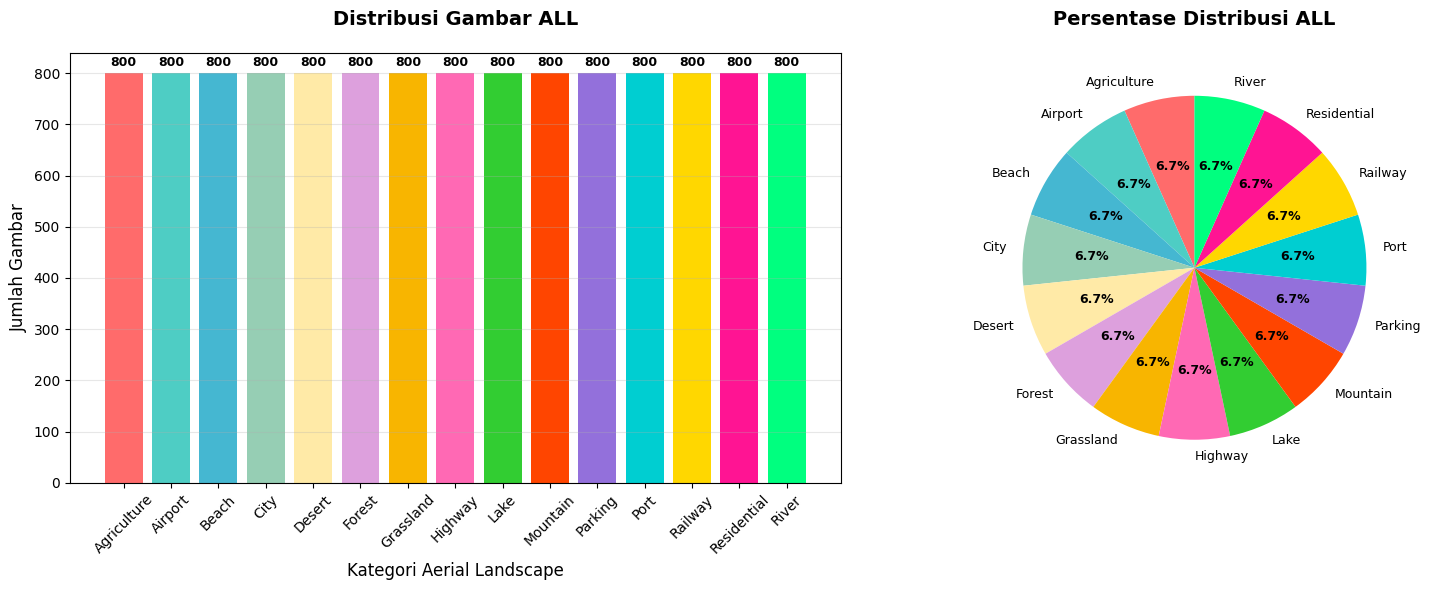


RINGKASAN STATISTIK DISTRIBUSI

ALL:
   - Total gambar: 12000
   - Rata-rata gambar per kategori: 800
   - Kategori terbanyak: Agriculture (800 gambar)
   - Kategori tersedikit: Agriculture (800 gambar)
   - Status: Dataset seimbang sempurna


In [3]:
# Analisis Distribusi Data

def analyze_dataset_distribution(splits, categories):
    """Analyze distribution of images across splits and categories"""
    if not splits or not categories:
        print("ERROR: Data splits atau categories tidak valid!")
        return None

    print(f"\nANALISIS DISTRIBUSI DATASET")
    print("=" * 60)

    distribution_data = {}

    for split_name, split_path in splits.items():
        print(f"\n{split_name.upper()}:")
        print("-" * 30)

        split_data = {}
        total_split = 0

        for i, category in enumerate(categories, 1):
            category_path = os.path.join(split_path, category)
            if os.path.exists(category_path):
                image_files = [f for f in os.listdir(category_path)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif',
                                                  '.jfif', '.bmp', '.tiff', '.tif', '.webp'))]
                count = len(image_files)
                split_data[category] = count
                total_split += count
                print(f"{i:2d}. {category:<12} : {count:>4} gambar")
            else:
                split_data[category] = 0
                print(f"{i:2d}. {category:<12} : {0:>4} gambar (folder tidak ada)")

        print("-" * 30)
        print(f"TOTAL {split_name.upper():<8} : {total_split:>4} gambar")
        distribution_data[split_name] = split_data

    print("=" * 60)
    return distribution_data

def visualize_dataset_distribution(distribution_data, categories):
    """Visualize dataset distribution with bar charts and pie charts"""
    if not distribution_data:
        print("ERROR: Tidak ada data untuk divisualisasikan!")
        return

    print(f"\nVISUALISASI DISTRIBUSI DATASET")
    print("=" * 60)

    splits = list(distribution_data.keys())

    # Calculate figure size based on number of splits
    fig_height = max(6, 4 * len(splits))
    fig, axes = plt.subplots(len(splits), 2, figsize=(16, fig_height))

    # Handle single split case
    if len(splits) == 1:
        axes = axes.reshape(1, -1)

    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD',
              '#F8B500', '#FF69B4', '#32CD32', '#FF4500', '#9370DB', '#00CED1',
              '#FFD700', '#FF1493', '#00FF7F']

    for i, split_name in enumerate(splits):
        split_data = distribution_data[split_name]
        counts = [split_data.get(cat, 0) for cat in categories]
        total_images = sum(counts)

        # Bar chart
        bars = axes[i, 0].bar(categories, counts, color=colors[:len(categories)])
        axes[i, 0].set_title(f'Distribusi Gambar {split_name.upper()}',
                            fontsize=14, fontweight='bold', pad=20)
        axes[i, 0].set_xlabel('Kategori Aerial Landscape', fontsize=12)
        axes[i, 0].set_ylabel('Jumlah Gambar', fontsize=12)
        axes[i, 0].tick_params(axis='x', rotation=45, labelsize=10)
        axes[i, 0].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            if count > 0:
                axes[i, 0].text(bar.get_x() + bar.get_width()/2,
                               bar.get_height() + max(counts)*0.01,
                               str(count), ha='center', va='bottom',
                               fontweight='bold', fontsize=9)

        # Pie chart (only if there are images)
        if total_images > 0:
            wedges, texts, autotexts = axes[i, 1].pie(counts, labels=categories,
                                                     autopct='%1.1f%%',
                                                     colors=colors[:len(categories)],
                                                     startangle=90,
                                                     textprops={'fontsize': 9})
            axes[i, 1].set_title(f'Persentase Distribusi {split_name.upper()}',
                                fontsize=14, fontweight='bold', pad=20)

            # Make percentage text bold
            for autotext in autotexts:
                autotext.set_fontweight('bold')
        else:
            axes[i, 1].text(0.5, 0.5, 'Tidak ada data untuk ditampilkan',
                           ha='center', va='center', transform=axes[i, 1].transAxes,
                           fontsize=12, fontweight='bold')
            axes[i, 1].set_title(f'Persentase Distribusi {split_name.upper()}',
                                fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

def print_distribution_summary(distribution_data, categories):
    """Print summary statistics of the distribution"""
    if not distribution_data:
        print("ERROR: Tidak ada data untuk dianalisis!")
        return

    print(f"\nRINGKASAN STATISTIK DISTRIBUSI")
    print("=" * 60)

    for split_name, split_data in distribution_data.items():
        counts = [split_data.get(cat, 0) for cat in categories]
        total_images = sum(counts)

        if total_images > 0:
            avg_images = total_images / len(categories)
            max_count = max(counts)
            min_count = min(counts)
            max_category = categories[counts.index(max_count)]
            min_category = categories[counts.index(min_count)]

            print(f"\n{split_name.upper()}:")
            print(f"   - Total gambar: {total_images}")
            print(f"   - Rata-rata gambar per kategori: {avg_images:.0f}")
            print(f"   - Kategori terbanyak: {max_category} ({max_count} gambar)")
            print(f"   - Kategori tersedikit: {min_category} ({min_count} gambar)")

            # Check balance
            if max_count == min_count:
                print(f"   - Status: Dataset seimbang sempurna")
            elif (max_count - min_count) / avg_images <= 0.1:
                print(f"   - Status: Dataset sangat seimbang")
            elif (max_count - min_count) / avg_images <= 0.3:
                print(f"   - Status: Dataset cukup seimbang")
            else:
                print(f"   - Status: Dataset tidak seimbang")
        else:
            print(f"\n{split_name.upper()}:")
            print(f"   - Tidak ada gambar ditemukan")

# Execute the functions
if 'distribution_data' in locals() or 'distribution_data' in globals():
    del distribution_data

distribution_data = analyze_dataset_distribution(splits, categories)
if distribution_data:
    visualize_dataset_distribution(distribution_data, categories)
    print_distribution_summary(distribution_data, categories)

### Data Preprocessing

#### Split Dataset


SPLIT DATASET
Pembagian dataset:
   - Training   : 70.0% (70%)
   - Validation : 15.0% (15%)
   - Testing    : 15.0% (15%)
------------------------------------------------------------
Agriculture  : Train=560, Val=120, Test=120, Total=800
Airport      : Train=560, Val=120, Test=120, Total=800
Beach        : Train=560, Val=120, Test=120, Total=800
City         : Train=560, Val=120, Test=120, Total=800
Desert       : Train=560, Val=120, Test=120, Total=800
Forest       : Train=560, Val=120, Test=120, Total=800
Grassland    : Train=560, Val=120, Test=120, Total=800
Highway      : Train=560, Val=120, Test=120, Total=800
Lake         : Train=560, Val=120, Test=120, Total=800
Mountain     : Train=560, Val=120, Test=120, Total=800
Parking      : Train=560, Val=120, Test=120, Total=800
Port         : Train=560, Val=120, Test=120, Total=800
Railway      : Train=560, Val=120, Test=120, Total=800
Residential  : Train=560, Val=120, Test=120, Total=800
River        : Train=560, Val=120, Test=120, 

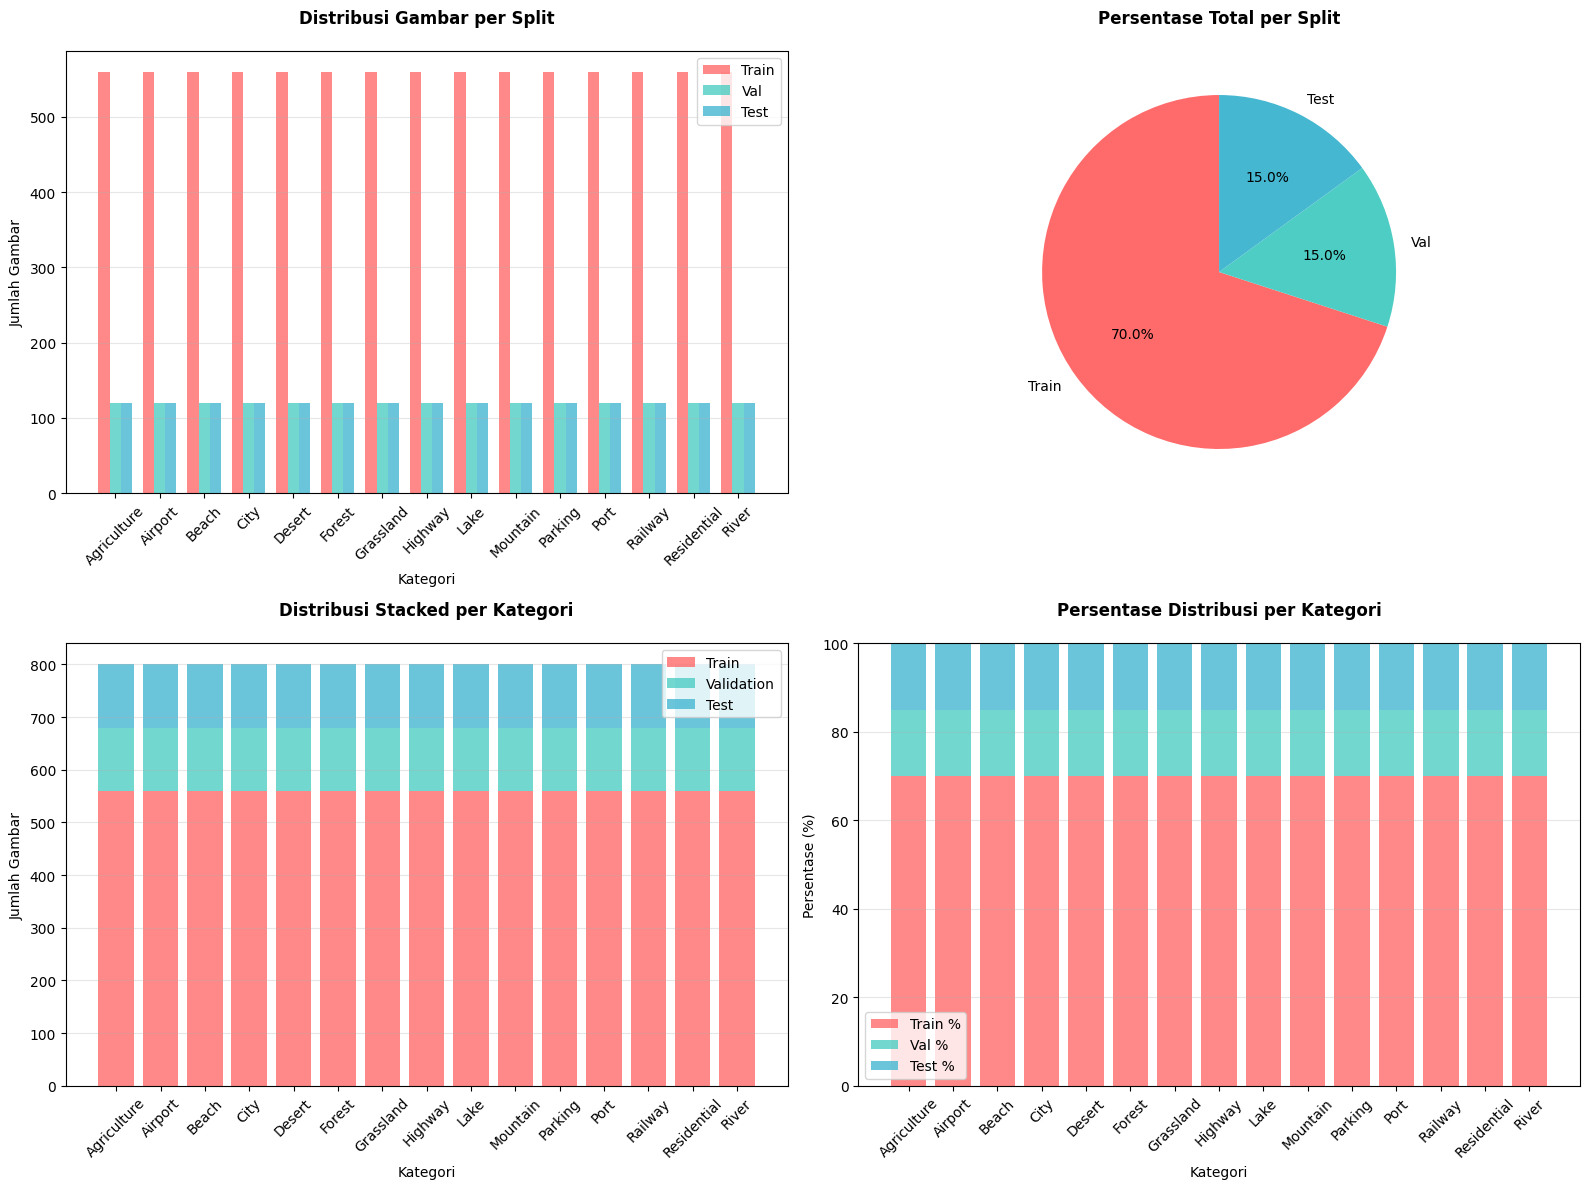

In [4]:
# Split Dataset menjadi Train, Validation, dan Test Set

import shutil
from sklearn.model_selection import train_test_split
import random

def split_dataset(dataset_path, categories, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, output_dir='dataset_split'):
    """
    Split dataset menjadi train, validation, dan test set

    Args:
        dataset_path: Path ke folder dataset utama
        categories: List kategori/kelas
        train_ratio: Proporsi data untuk training (default: 0.7 = 70%)
        val_ratio: Proporsi data untuk validation (default: 0.15 = 15%)
        test_ratio: Proporsi data untuk testing (default: 0.15 = 15%)
        output_dir: Nama folder output untuk dataset yang sudah di-split

    Returns:
        Dictionary berisi path ke masing-masing split
    """

    # Validasi ratio
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 0.001:
        print("ERROR: Total ratio harus sama dengan 1.0!")
        return None

    print(f"\nSPLIT DATASET")
    print("=" * 60)
    print(f"Pembagian dataset:")
    print(f"   - Training   : {train_ratio:.1%} ({train_ratio*100:.0f}%)")
    print(f"   - Validation : {val_ratio:.1%} ({val_ratio*100:.0f}%)")
    print(f"   - Testing    : {test_ratio:.1%} ({test_ratio*100:.0f}%)")
    print("-" * 60)

    # Create output directory structure
    base_output_path = os.path.join(os.getcwd(), output_dir)

    # Create directories for each split
    splits = ['train', 'val', 'test']
    split_paths = {}

    for split in splits:
        split_path = os.path.join(base_output_path, split)
        split_paths[split] = split_path
        os.makedirs(split_path, exist_ok=True)

        # Create category subdirectories
        for category in categories:
            category_path = os.path.join(split_path, category)
            os.makedirs(category_path, exist_ok=True)

    # Process each category
    split_summary = {split: {cat: 0 for cat in categories} for split in splits}

    for category in categories:
        category_path = os.path.join(dataset_path, category)

        # Get all image files
        image_files = [f for f in os.listdir(category_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif',
                                           '.jfif', '.bmp', '.tiff', '.tif', '.webp'))]

        # Shuffle files for random distribution
        random.shuffle(image_files)

        total_images = len(image_files)

        # Calculate split sizes
        train_size = int(total_images * train_ratio)
        val_size = int(total_images * val_ratio)
        test_size = total_images - train_size - val_size  # Remaining images go to test

        # Split files
        train_files = image_files[:train_size]
        val_files = image_files[train_size:train_size + val_size]
        test_files = image_files[train_size + val_size:]

        # Copy files to respective directories
        file_splits = {
            'train': train_files,
            'val': val_files,
            'test': test_files
        }

        for split_name, files in file_splits.items():
            for file in files:
                src_path = os.path.join(category_path, file)
                dst_path = os.path.join(split_paths[split_name], category, file)
                shutil.copy2(src_path, dst_path)

            split_summary[split_name][category] = len(files)

        print(f"{category:<12} : Train={len(train_files):>3}, Val={len(val_files):>3}, Test={len(test_files):>3}, Total={total_images:>3}")

    print("-" * 60)

    # Print summary
    total_train = sum(split_summary['train'].values())
    total_val = sum(split_summary['val'].values())
    total_test = sum(split_summary['test'].values())
    total_all = total_train + total_val + total_test

    print(f"RINGKASAN SPLIT:")
    print(f"   - Training   : {total_train:>4} gambar ({total_train/total_all:.1%})")
    print(f"   - Validation : {total_val:>4} gambar ({total_val/total_all:.1%})")
    print(f"   - Testing    : {total_test:>4} gambar ({total_test/total_all:.1%})")
    print(f"   - TOTAL      : {total_all:>4} gambar")

    print(f"\nDataset berhasil di-split dan disimpan di: {base_output_path}")
    print("=" * 60)

    return split_paths, split_summary

def verify_split_balance(split_summary, categories):
    """Verifikasi keseimbangan dataset setelah split"""
    print(f"\nVERIFIKASI KESEIMBANGAN DATASET")
    print("=" * 60)

    for split_name, split_data in split_summary.items():
        counts = [split_data[cat] for cat in categories]
        total_images = sum(counts)

        if total_images > 0:
            avg_images = total_images / len(categories)
            max_count = max(counts)
            min_count = min(counts)

            print(f"\n{split_name.upper()}:")
            print(f"   - Total: {total_images} gambar")
            print(f"   - Rata-rata per kategori: {avg_images:.1f}")
            print(f"   - Range: {min_count} - {max_count} gambar")

            # Check balance
            if max_count == min_count:
                balance_status = "Seimbang Sempurna"
            elif (max_count - min_count) <= 2:
                balance_status = "Sangat Seimbang"
            elif (max_count - min_count) <= 5:
                balance_status = "Cukup Seimbang"
            else:
                balance_status = "Tidak Seimbang"

            print(f"   - Status: {balance_status}")

def visualize_split_distribution(split_summary, categories):
    """Visualisasi distribusi dataset setelah split"""
    print(f"\nVISUALISASI DISTRIBUSI SETELAH SPLIT")
    print("=" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD',
              '#F8B500', '#FF69B4', '#32CD32', '#FF4500', '#9370DB', '#00CED1',
              '#FFD700', '#FF1493', '#00FF7F']

    # 1. Bar chart comparison
    splits = ['train', 'val', 'test']
    x = np.arange(len(categories))
    width = 0.25

    for i, split in enumerate(splits):
        counts = [split_summary[split][cat] for cat in categories]
        axes[0, 0].bar(x + i*width, counts, width, label=split.capitalize(),
                      color=colors[i], alpha=0.8)

    axes[0, 0].set_title('Distribusi Gambar per Split', fontweight='bold', pad=20)
    axes[0, 0].set_xlabel('Kategori')
    axes[0, 0].set_ylabel('Jumlah Gambar')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(categories, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)

    # 2. Pie chart - Total per split
    split_totals = [sum(split_summary[split].values()) for split in splits]
    axes[0, 1].pie(split_totals, labels=[s.capitalize() for s in splits],
                  autopct='%1.1f%%', colors=colors[:3], startangle=90)
    axes[0, 1].set_title('Persentase Total per Split', fontweight='bold', pad=20)

    # 3. Stacked bar chart
    train_counts = [split_summary['train'][cat] for cat in categories]
    val_counts = [split_summary['val'][cat] for cat in categories]
    test_counts = [split_summary['test'][cat] for cat in categories]

    axes[1, 0].bar(categories, train_counts, label='Train', color=colors[0], alpha=0.8)
    axes[1, 0].bar(categories, val_counts, bottom=train_counts, label='Validation',
                  color=colors[1], alpha=0.8)
    axes[1, 0].bar(categories, test_counts,
                  bottom=[t+v for t,v in zip(train_counts, val_counts)],
                  label='Test', color=colors[2], alpha=0.8)

    axes[1, 0].set_title('Distribusi Stacked per Kategori', fontweight='bold', pad=20)
    axes[1, 0].set_xlabel('Kategori')
    axes[1, 0].set_ylabel('Jumlah Gambar')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 4. Percentage distribution per category
    percentages = []
    for cat in categories:
        total_cat = (split_summary['train'][cat] +
                    split_summary['val'][cat] +
                    split_summary['test'][cat])
        if total_cat > 0:
            train_pct = split_summary['train'][cat] / total_cat * 100
            val_pct = split_summary['val'][cat] / total_cat * 100
            test_pct = split_summary['test'][cat] / total_cat * 100
            percentages.append([train_pct, val_pct, test_pct])
        else:
            percentages.append([0, 0, 0])

    percentages = np.array(percentages)

    axes[1, 1].bar(categories, percentages[:, 0], label='Train %',
                  color=colors[0], alpha=0.8)
    axes[1, 1].bar(categories, percentages[:, 1], bottom=percentages[:, 0],
                  label='Val %', color=colors[1], alpha=0.8)
    axes[1, 1].bar(categories, percentages[:, 2],
                  bottom=percentages[:, 0] + percentages[:, 1],
                  label='Test %', color=colors[2], alpha=0.8)

    axes[1, 1].set_title('Persentase Distribusi per Kategori', fontweight='bold', pad=20)
    axes[1, 1].set_xlabel('Kategori')
    axes[1, 1].set_ylabel('Persentase (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0, 100)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Execute the functions
if dataset_gambar_path and categories:
    # Set random seed for reproducible results
    random.seed(42)
    np.random.seed(42)

    # Split dataset (70% train, 15% val, 15% test)
    split_paths, split_summary = split_dataset(
        dataset_gambar_path,
        categories,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )

    if split_paths and split_summary:
        verify_split_balance(split_summary, categories)
        visualize_split_distribution(split_summary, categories)

MENJALANKAN SETUP DATA GENERATORS...

SETUP DATA GENERATORS
Konfigurasi:
   - Target size    : (128, 128)
   - Batch size     : 32
   - Augmentasi     : Hanya untuk data training
   - Normalisasi    : Semua data (rescale ke 0-1)
------------------------------------------------------------

VALIDASI PATH DATASET

TRAIN:
------------------------------
Agriculture  : 560 gambar
Airport      : 560 gambar
Beach        : 560 gambar
City         : 560 gambar
Desert       : 560 gambar
Forest       : 560 gambar
Grassland    : 560 gambar
Highway      : 560 gambar
Lake         : 560 gambar
Mountain     : 560 gambar
Parking      : 560 gambar
Port         : 560 gambar
Railway      : 560 gambar
Residential  : 560 gambar
River        : 560 gambar
TOTAL TRAIN    : 8400 gambar

VAL:
------------------------------
Agriculture  : 120 gambar
Airport      : 120 gambar
Beach        : 120 gambar
City         : 120 gambar
Desert       : 120 gambar
Forest       : 120 gambar
Grassland    : 120 gambar
Highway   

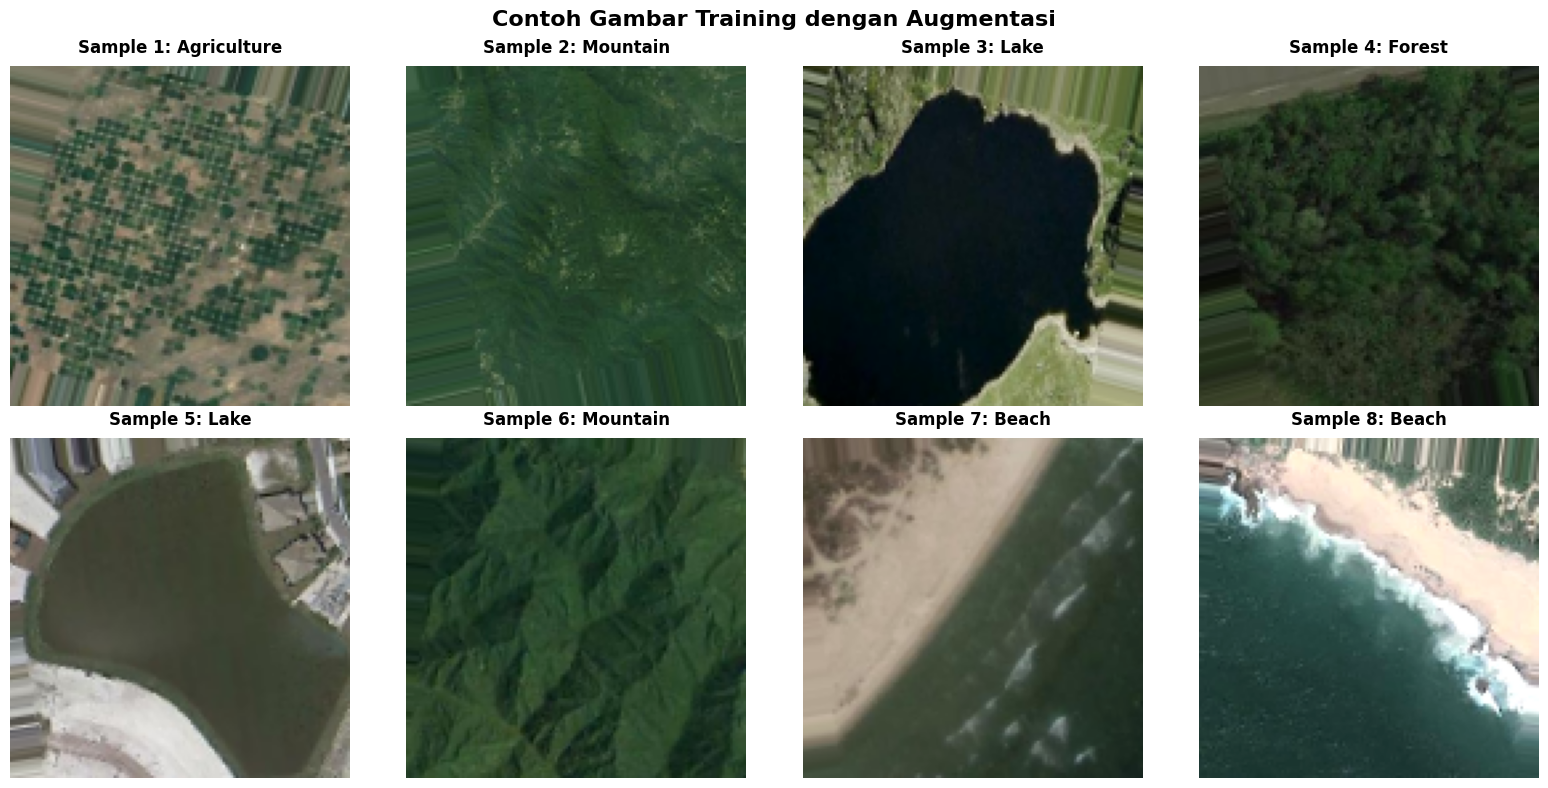

Visualisasi menampilkan gambar training yang sudah di-augmentasi
(rotasi, shift, zoom, flip, brightness variation)

RINGKASAN PIPELINE DATA
PATH DATASET:
   - Train        : /content/dataset_split/train
   - Val          : /content/dataset_split/val
   - Test         : /content/dataset_split/test

DISTRIBUSI DATA:
   - Training   : 8400 samples (70.0%)
   - Validation : 1800 samples (15.0%)
   - Testing    : 1800 samples (15.0%)

KONFIGURASI:
   - Image size     : (128, 128)
   - Batch size     : 32
   - Number classes : 15
   - Steps per epoch: 262
   - Val steps      : 56

STATUS PIPELINE:
   - Dataset loaded and validated
   - Data split completed (train/val/test)
   - Generators created with augmentation
   - Ready for model training
   - Ready for validation
   - Ready for inference

PIPELINE DATA SIAP DIGUNAKAN!
Selanjutnya Anda dapat:
   1. Membuat model CNN
   2. Training model dengan train_gen
   3. Validasi dengan val_gen
   4. Testing dengan test_gen


In [5]:
# Setup Data Generators dengan Augmentasi
# Data Generator dengan augmentasi hanya untuk training data

def validate_split_paths(split_paths, categories):
    """Validasi path dari hasil split dataset"""
    print(f"\nVALIDASI PATH DATASET")
    print("=" * 60)

    if not split_paths:
        print("ERROR: split_paths tidak ditemukan!")
        return False

    validation_results = {}
    total_issues = 0

    for split_name, split_path in split_paths.items():
        print(f"\n{split_name.upper()}:")
        print("-" * 30)

        if not os.path.exists(split_path):
            print(f"ERROR: Path tidak ditemukan - {split_path}")
            validation_results[split_name] = False
            total_issues += 1
            continue

        split_valid = True
        split_total = 0

        for category in categories:
            category_path = os.path.join(split_path, category)
            if os.path.exists(category_path):
                image_files = [f for f in os.listdir(category_path)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif',
                                                  '.jfif', '.bmp', '.tiff', '.tif', '.webp'))]
                count = len(image_files)
                split_total += count

                if count > 0:
                    print(f"{category:<12} : {count:>3} gambar")
                else:
                    print(f"{category:<12} : {count:>3} gambar (kosong)")
            else:
                print(f"{category:<12} : Folder tidak ditemukan")
                split_valid = False
                total_issues += 1

        print(f"TOTAL {split_name.upper():<8} : {split_total:>3} gambar")
        validation_results[split_name] = split_valid

    print("-" * 60)
    if total_issues == 0:
        print("VALIDASI BERHASIL: Semua path dan folder valid!")
    else:
        print(f"VALIDASI GAGAL: Ditemukan {total_issues} masalah!")

    print("=" * 60)
    return total_issues == 0

def setup_data_generators(split_paths, categories, target_size=(128, 128), batch_size=32):
    """
    Setup data generators dengan augmentasi HANYA untuk training data

    Args:
        split_paths: Dictionary berisi path ke train, val, test
        categories: List kategori/kelas
        target_size: Ukuran target untuk resize gambar
        batch_size: Ukuran batch untuk training

    Returns:
        train_generator, validation_generator, test_generator, class_names, generator_info
    """

    print(f"\nSETUP DATA GENERATORS")
    print("=" * 60)
    print(f"Konfigurasi:")
    print(f"   - Target size    : {target_size}")
    print(f"   - Batch size     : {batch_size}")
    print(f"   - Augmentasi     : Hanya untuk data training")
    print(f"   - Normalisasi    : Semua data (rescale ke 0-1)")
    print("-" * 60)

    # Validasi path terlebih dahulu
    if not validate_split_paths(split_paths, categories):
        print("ERROR: Validasi path gagal!")
        return None, None, None, None, None

    # Data augmentation HANYA untuk training data
    print(f"\nAUGMENTASI TRAINING DATA:")
    train_datagen = ImageDataGenerator(
        rescale=1./255,                    # Normalisasi ke 0-1
        rotation_range=15,                 # Rotasi ±15 derajat
        width_shift_range=0.1,            # Shift horizontal ±10%
        height_shift_range=0.1,           # Shift vertikal ±10%
        zoom_range=0.1,                   # Zoom ±10%
        horizontal_flip=True,             # Flip horizontal random
        brightness_range=[0.9, 1.1],     # Variasi brightness
        fill_mode='nearest'               # Fill mode untuk transformasi
    )

    augmentation_params = [
        "   - Rescaling: 0-1 normalization",
        "   - Rotation: ±15 degrees",
        "   - Width shift: ±10%",
        "   - Height shift: ±10%",
        "   - Zoom: ±10%",
        "   - Horizontal flip: Random",
        "   - Brightness: 90%-110%",
        "   - Fill mode: Nearest neighbor"
    ]

    for param in augmentation_params:
        print(param)

    # TIDAK ada augmentasi untuk validation dan test data - hanya rescaling
    print(f"\nNORMALISASI VALIDATION & TEST DATA:")
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    print("   - Rescaling: 0-1 normalization only")
    print("   - No augmentation (untuk konsistensi evaluasi)")

    print(f"\nMEMBUAT GENERATORS...")

    try:
        # Training generator
        train_generator = train_datagen.flow_from_directory(
            split_paths['train'],
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
        print("   - Training generator berhasil dibuat")

        # Validation generator
        validation_generator = val_test_datagen.flow_from_directory(
            split_paths['val'],
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )
        print("   - Validation generator berhasil dibuat")

        # Test generator
        test_generator = val_test_datagen.flow_from_directory(
            split_paths['test'],
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )
        print("   - Test generator berhasil dibuat")

    except Exception as e:
        print(f"ERROR saat membuat generators: {e}")
        return None, None, None, None, None

    # Get class information
    num_classes = train_generator.num_classes
    class_names = list(train_generator.class_indices.keys())

    # Informasi generator
    print(f"\nINFORMASI GENERATORS:")
    print(f"   - Jumlah kelas       : {num_classes}")
    print(f"   - Training samples   : {train_generator.samples}")
    print(f"   - Validation samples : {validation_generator.samples}")
    print(f"   - Test samples       : {test_generator.samples}")
    print(f"   - Steps per epoch    : {train_generator.samples // batch_size}")
    print(f"   - Validation steps   : {validation_generator.samples // batch_size}")

    print(f"\nMAPPING KELAS:")
    class_indices = train_generator.class_indices
    for i, (class_name, class_index) in enumerate(sorted(class_indices.items(), key=lambda x: x[1])):
        print(f"   {class_index:2d}. {class_name}")

    # Generator info untuk keperluan selanjutnya
    generator_info = {
        'num_classes': num_classes,
        'class_names': class_names,
        'class_indices': class_indices,
        'target_size': target_size,
        'batch_size': batch_size,
        'train_samples': train_generator.samples,
        'val_samples': validation_generator.samples,
        'test_samples': test_generator.samples,
        'steps_per_epoch': train_generator.samples // batch_size,
        'validation_steps': validation_generator.samples // batch_size
    }

    print("=" * 60)
    print("DATA GENERATORS SIAP UNTUK TRAINING!")
    print("=" * 60)

    return train_generator, validation_generator, test_generator, class_names, generator_info

def visualize_augmented_samples(train_generator, class_names, num_samples=8):
    """Visualisasi contoh gambar yang sudah di-augmentasi"""
    print(f"\nVISUALISASI AUGMENTED SAMPLES")
    print("=" * 60)

    # Get one batch of augmented images
    batch_images, batch_labels = next(train_generator)

    # Plot augmented samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_samples, len(batch_images))):
        # Get class label
        class_idx = np.argmax(batch_labels[i])
        class_name = class_names[class_idx]

        # Display image
        axes[i].imshow(batch_images[i])
        axes[i].set_title(f'Sample {i+1}: {class_name}', fontweight='bold', pad=10)
        axes[i].axis('off')

    plt.suptitle('Contoh Gambar Training dengan Augmentasi', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print("Visualisasi menampilkan gambar training yang sudah di-augmentasi")
    print("(rotasi, shift, zoom, flip, brightness variation)")

def show_pipeline_summary(split_paths, generator_info):
    """Tampilkan ringkasan lengkap pipeline data"""
    print(f"\nRINGKASAN PIPELINE DATA")
    print("=" * 60)

    print(f"PATH DATASET:")
    for split_name, split_path in split_paths.items():
        print(f"   - {split_name.capitalize():<12} : {split_path}")

    total_samples = generator_info['train_samples'] + generator_info['val_samples'] + generator_info['test_samples']

    print(f"\nDISTRIBUSI DATA:")
    print(f"   - Training   : {generator_info['train_samples']:>4} samples ({generator_info['train_samples']/total_samples:.1%})")
    print(f"   - Validation : {generator_info['val_samples']:>4} samples ({generator_info['val_samples']/total_samples:.1%})")
    print(f"   - Testing    : {generator_info['test_samples']:>4} samples ({generator_info['test_samples']/total_samples:.1%})")

    print(f"\nKONFIGURASI:")
    print(f"   - Image size     : {generator_info['target_size']}")
    print(f"   - Batch size     : {generator_info['batch_size']}")
    print(f"   - Number classes : {generator_info['num_classes']}")
    print(f"   - Steps per epoch: {generator_info['steps_per_epoch']}")
    print(f"   - Val steps      : {generator_info['validation_steps']}")

    print(f"\nSTATUS PIPELINE:")
    print(f"   - Dataset loaded and validated")
    print(f"   - Data split completed (train/val/test)")
    print(f"   - Generators created with augmentation")
    print(f"   - Ready for model training")
    print(f"   - Ready for validation")
    print(f"   - Ready for inference")

    print("=" * 60)

# Execute the functions (pastikan variabel dari fungsi sebelumnya tersedia)
if 'split_paths' in locals() and 'categories' in locals():
    print("MENJALANKAN SETUP DATA GENERATORS...")

    # Setup data generators
    train_gen, val_gen, test_gen, class_names, gen_info = setup_data_generators(
        split_paths,
        categories,
        target_size=(128, 128),
        batch_size=32
    )

    if train_gen is not None:
        # Visualize augmented samples
        visualize_augmented_samples(train_gen, class_names, num_samples=8)

        # Show complete pipeline summary
        show_pipeline_summary(split_paths, gen_info)

        print("\nPIPELINE DATA SIAP DIGUNAKAN!")
        print("Selanjutnya Anda dapat:")
        print("   1. Membuat model CNN")
        print("   2. Training model dengan train_gen")
        print("   3. Validasi dengan val_gen")
        print("   4. Testing dengan test_gen")

    else:
        print("Gagal membuat data generators!")

else:
    print("PERINGATAN: Variabel split_paths dan categories tidak ditemukan!")
    print("Pastikan Anda telah menjalankan fungsi split_dataset terlebih dahulu.")

## Modelling

In [6]:
#Create Model

def create_optimized_cnn_model(input_shape=(128, 128, 3), num_classes=15):
    """
    Create optimized CNN model with MobileNetV2 transfer learning
    """
    print("\nMEMBANGUN MODEL CNN OPTIMIZED")
    print("=" * 60)
    print(f"Input shape: {input_shape}")
    print(f"Jumlah kelas: {num_classes}")
    print("-" * 60)

    # Create base model with MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling=None
    )

    # Freeze base model initially
    base_model.trainable = False
    print("Base model (MobileNetV2) berhasil dimuat")
    print("Base model layers: FROZEN (untuk transfer learning)")

    # Build complete model
    model = tf.keras.Sequential([
        base_model,
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='custom_conv1'),
        layers.BatchNormalization(name='custom_bn1'),
        layers.MaxPooling2D((2, 2), name='custom_pool1'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='custom_conv2'),
        layers.BatchNormalization(name='custom_bn2'),
        layers.GlobalAveragePooling2D(name='custom_gap'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.2, name='dropout_2'),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ], name='optimized_land_classifier')

    print("Custom layers berhasil ditambahkan")
    print("Model optimized berhasil dibuat!")
    print("=" * 60)

    return model


#  CREATE MODEL INSTANCE
model = create_optimized_cnn_model(
    input_shape=(128, 128, 3),
    num_classes=15  # Sesuai dengan jumlah kelas dataset
)


# COMPILE MODEL (LEARNING RATE DISESUAIKAN)
def compile_model(model, learning_rate=0.0001):  # DIKURANGI dari 0.001 ke 0.0001
    """Compile model with Adam optimizer"""
    print("\nKOMPILASI MODEL")
    print("=" * 60)
    print(f"Optimizer: Adam")
    print(f"Learning rate: {learning_rate} (DIKURANGI untuk stabilitas)")
    print(f"Loss function: categorical_crossentropy")
    print(f"Metrics: accuracy")
    print("-" * 60)

    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model berhasil dikompilasi dengan learning rate yang lebih kecil!")
    print("=" * 60)
    return model

#  COMPILE MODEL INSTANCE
compiled_model = compile_model(model, learning_rate=0.0001)  # Learning rate dikurangi


# DISPLAY MODEL SUMMARY
print("\nMODEL SUMMARY")
print("=" * 60)
model.summary()
print("=" * 60)


MEMBANGUN MODEL CNN OPTIMIZED
Input shape: (128, 128, 3)
Jumlah kelas: 15
------------------------------------------------------------
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model (MobileNetV2) berhasil dimuat
Base model layers: FROZEN (untuk transfer learning)
Custom layers berhasil ditambahkan
Model optimized berhasil dibuat!

KOMPILASI MODEL
Optimizer: Adam
Learning rate: 0.0001 (DIKURANGI untuk stabilitas)
Loss function: categorical_crossentropy
Metrics: accuracy
------------------------------------------------------------
Model berhasil dikompilasi dengan learning rate yang lebih kecil!

MODEL SUMMARY


Model: "optimized_land_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv1 (Conv2D)           │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_bn1 (BatchNormalization) │ (None, 4, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_pool1 (MaxPooling2D)     │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2 (Conv2D)           │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_bn2 (BatchNormalization) │ (None, 2, 2, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_gap                      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,817,487 (14.56 MB)

 Trainable params: 1,559,119 (5.95 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [8]:
# CALLBACK

def setup_callbacks(model_name='best_land_model'):
    """Setup training callbacks dengan pengaturan yang lebih konservatif"""
    print("\nSETUP CALLBACKS")
    print("=" * 60)

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # Ditingkatkan dari 8 ke 10
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0005  # Dikurangi dari 0.001 ke 0.0005
    )

    model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Dikurangi dari 0.3 ke 0.5 (pengurangan yang lebih gradual)
        patience=5,  # Ditingkatkan dari 4 ke 5
        min_lr=1e-7,  # Dikurangi dari 1e-6 ke 1e-7
        verbose=1
    )

    callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

    print("CALLBACK CONFIGURATION (DISESUAIKAN):")
    print("   - Early Stopping:")
    print("     Monitor: val_accuracy")
    print("     Patience: 10 epochs (ditingkatkan)")
    print("     Min delta: 0.0005 (dikurangi)")
    print("   - Model Checkpoint:")
    print(f"     Filepath: {model_name}.keras")
    print("     Save best only: True")
    print("   - Reduce LR on Plateau:")
    print("     Monitor: val_loss")
    print("     Factor: 0.5 (lebih gradual)")
    print("     Patience: 5 epochs (ditingkatkan)")
    print("     Min LR: 1e-7 (lebih kecil)")
    print("-" * 60)
    print("Callbacks berhasil diatur dengan pengaturan yang lebih konservatif!")
    print("=" * 60)

    return callbacks_list

#  SETUP CALLBACKS INSTANCE
callbacks = setup_callbacks(model_name='best_land_classifier')



SETUP CALLBACKS
CALLBACK CONFIGURATION (DISESUAIKAN):
   - Early Stopping:
     Monitor: val_accuracy
     Patience: 10 epochs (ditingkatkan)
     Min delta: 0.0005 (dikurangi)
   - Model Checkpoint:
     Filepath: best_land_classifier.keras
     Save best only: True
   - Reduce LR on Plateau:
     Monitor: val_loss
     Factor: 0.5 (lebih gradual)
     Patience: 5 epochs (ditingkatkan)
     Min LR: 1e-7 (lebih kecil)
------------------------------------------------------------
Callbacks berhasil diatur dengan pengaturan yang lebih konservatif!


In [9]:
#  FUNGSI TRAIN MODEL
def train_model(model, train_gen, val_gen, callbacks, epochs=30):  # Epochs ditingkatkan
    """Train the model"""
    print(f"\nMEMULAI TRAINING MODEL")
    print("=" * 60)
    print(f"Model name: {model.name}")
    print(f"Epochs: {epochs} (ditingkatkan untuk kompensasi learning rate kecil)")
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Steps per epoch: {len(train_gen)}")
    print(f"Validation steps: {len(val_gen)}")
    print("-" * 60)

    start_time = time.time()
    print("Training dimulai dengan learning rate yang lebih kecil...")

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    end_time = time.time()
    training_time = end_time - start_time

    print("-" * 60)
    print("TRAINING SELESAI!")
    print(f"Total waktu training: {training_time:.2f} detik")
    print(f"Total waktu training: {training_time/60:.2f} menit")

    # Training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])

    print("\nHASIL TRAINING:")
    print(f"   - Final training accuracy: {final_train_acc:.4f}")
    print(f"   - Final validation accuracy: {final_val_acc:.4f}")
    print(f"   - Best validation accuracy: {best_val_acc:.4f}")
    print(f"   - Final training loss: {final_train_loss:.4f}")
    print(f"   - Final validation loss: {final_val_loss:.4f}")
    print(f"   - Best validation loss: {best_val_loss:.4f}")
    print("=" * 60)

    return history

# TRAINING MODEL
history = train_model(
    model, train_gen, val_gen, callbacks, epochs=30  # Epochs ditingkatkan
)

# FINE TUNE MODEL (LEARNING RATE LEBIH KECIL)
def fine_tune_model(model, train_gen, val_gen, callbacks, epochs=15):  # Epochs ditingkatkan
    """Fine-tune the model by unfreezing some layers"""
    print("\nFINE-TUNING MODEL")
    print("=" * 60)

    # Check if model has base_model (transfer learning)
    if hasattr(model.layers[0], 'layers'):
        # Unfreeze base model
        base_model = model.layers[0]
        base_model.trainable = True

        # Freeze early layers
        frozen_layers = 0
        unfrozen_layers = 0

        for layer in base_model.layers[:-20]:
            layer.trainable = False
            frozen_layers += 1

        for layer in base_model.layers[-20:]:
            unfrozen_layers += 1

        print("FINE-TUNING CONFIGURATION:")
        print(f"   - Total base model layers: {len(base_model.layers)}")
        print(f"   - Frozen layers: {frozen_layers}")
        print(f"   - Unfrozen layers: {unfrozen_layers}")
        print(f"   - New learning rate: 0.00005 (DIKURANGI lebih drastis)")
        print("-" * 60)

        # Recompile with even lower learning rate
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Model berhasil dikompilasi ulang untuk fine-tuning dengan LR sangat kecil")

        start_time = time.time()
        print(f"Fine-tuning dimulai untuk {epochs} epochs...")

        history_ft = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )

        end_time = time.time()
        ft_time = end_time - start_time

        print("-" * 60)
        print("FINE-TUNING SELESAI!")
        print(f"Total waktu fine-tuning: {ft_time:.2f} detik")
        print(f"Total waktu fine-tuning: {ft_time/60:.2f} menit")

        # Fine-tuning summary
        final_train_acc = history_ft.history['accuracy'][-1]
        final_val_acc = history_ft.history['val_accuracy'][-1]
        best_val_acc = max(history_ft.history['val_accuracy'])
        final_train_loss = history_ft.history['loss'][-1]
        final_val_loss = history_ft.history['val_loss'][-1]
        best_val_loss = min(history_ft.history['val_loss'])

        print("\nHASIL FINE-TUNING:")
        print(f"   - Final training accuracy: {final_train_acc:.4f}")
        print(f"   - Final validation accuracy: {final_val_acc:.4f}")
        print(f"   - Best validation accuracy: {best_val_acc:.4f}")
        print(f"   - Final training loss: {final_train_loss:.4f}")
        print(f"   - Final validation loss: {final_val_loss:.4f}")
        print(f"   - Best validation loss: {best_val_loss:.4f}")
        print("=" * 60)

        return history_ft
    else:
        print("Model tidak memiliki base model untuk fine-tuning")
        print("Skip fine-tuning process")
        print("=" * 60)
        return None

# FINE-TUNING MODEL
history_ft = fine_tune_model(
    model, train_gen, val_gen, callbacks, epochs=15  # Epochs ditingkatkan
)


MEMULAI TRAINING MODEL
Model name: optimized_land_classifier
Epochs: 30 (ditingkatkan untuk kompensasi learning rate kecil)
Training samples: 8400
Validation samples: 1800
Steps per epoch: 263
Validation steps: 57
------------------------------------------------------------
Training dimulai dengan learning rate yang lebih kecil...
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.4138 - loss: 1.9440
Epoch 1: val_accuracy improved from -inf to 0.81278, saving model to best_land_classifier.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 233s 855ms/step - accuracy: 0.4144 - loss: 1.9423 - val_accuracy: 0.8128 - val_loss: 0.7492 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.7805 - loss: 0.8703
Epoch 2: val_accuracy improved from 0.81278 to 0.85000, saving model to best_land_classifier.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 214s 812ms/step - accuracy: 0.7805 - loss: 0.8701 - val_accuracy: 0.8500 - val_loss: 0.5466 - learning_rate: 1.0000e-

## Evaluasi dan Visualisasi

In [28]:
#  DEFINISI CLASS NAMES YANG BENAR

# Definisi class names yang sesuai dengan 15 kelas dalam dataset
class_names = [
    'Agriculture', 'Airport', 'Beach', 'City', 'Desert',
    'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain',
    'Parking', 'Port', 'Railway', 'Residential', 'River'
]

print("CLASS NAMES BERHASIL DIDEFINISIKAN:")
print("=" * 60)
for i, class_name in enumerate(class_names):
    print(f"{i:2d}. {class_name}")
print("=" * 60)
print(f"Total classes: {len(class_names)}")

CLASS NAMES BERHASIL DIDEFINISIKAN:
 0. Agriculture
 1. Airport
 2. Beach
 3. City
 4. Desert
 5. Forest
 6. Grassland
 7. Highway
 8. Lake
 9. Mountain
10. Parking
11. Port
12. Railway
13. Residential
14. River
Total classes: 15


In [29]:
#  EVALUASI MODEL PADA TEST SET (FIXED)

def evaluate_model_on_test_fixed(model, test_generator, class_names):
    """Evaluate model on test set - FIXED VERSION"""
    print("\nEVALUASI MODEL PADA TEST SET - FIXED")
    print("=" * 60)
    print(f"Model: {model.name}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Test steps: {len(test_generator)}")
    print(f"Number of classes: {len(class_names)}")
    print("-" * 60)

    # Reset generator
    test_generator.reset()

    start_time = time.time()
    print("Evaluating model on test set...")

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    end_time = time.time()
    eval_time = end_time - start_time

    print("-" * 60)
    print("EVALUASI SELESAI!")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Accuracy Percentage: {test_accuracy*100:.2f}%")
    print(f"Waktu evaluasi: {eval_time:.2f} detik")
    print("=" * 60)

    return test_loss, test_accuracy

# RUN EVALUASI
test_loss, test_accuracy = evaluate_model_on_test_fixed(model, test_gen, class_names)




EVALUASI MODEL PADA TEST SET - FIXED
Model: optimized_land_classifier
Test samples: 1800
Test steps: 57
Number of classes: 15
------------------------------------------------------------
Evaluating model on test set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 481ms/step - accuracy: 0.8914 - loss: 0.3884
------------------------------------------------------------
EVALUASI SELESAI!
Test Loss: 0.3319
Test Accuracy: 0.9089
Test Accuracy Percentage: 90.89%
Waktu evaluasi: 27.59 detik



MEMBUAT PREDIKSI DAN CONFUSION MATRIX - FIXED
Model: optimized_land_classifier
Classes: 15
------------------------------------------------------------
Generating predictions...
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 891ms/step
Total predictions: 1800
Total true labels: 1800
Unique predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique true classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


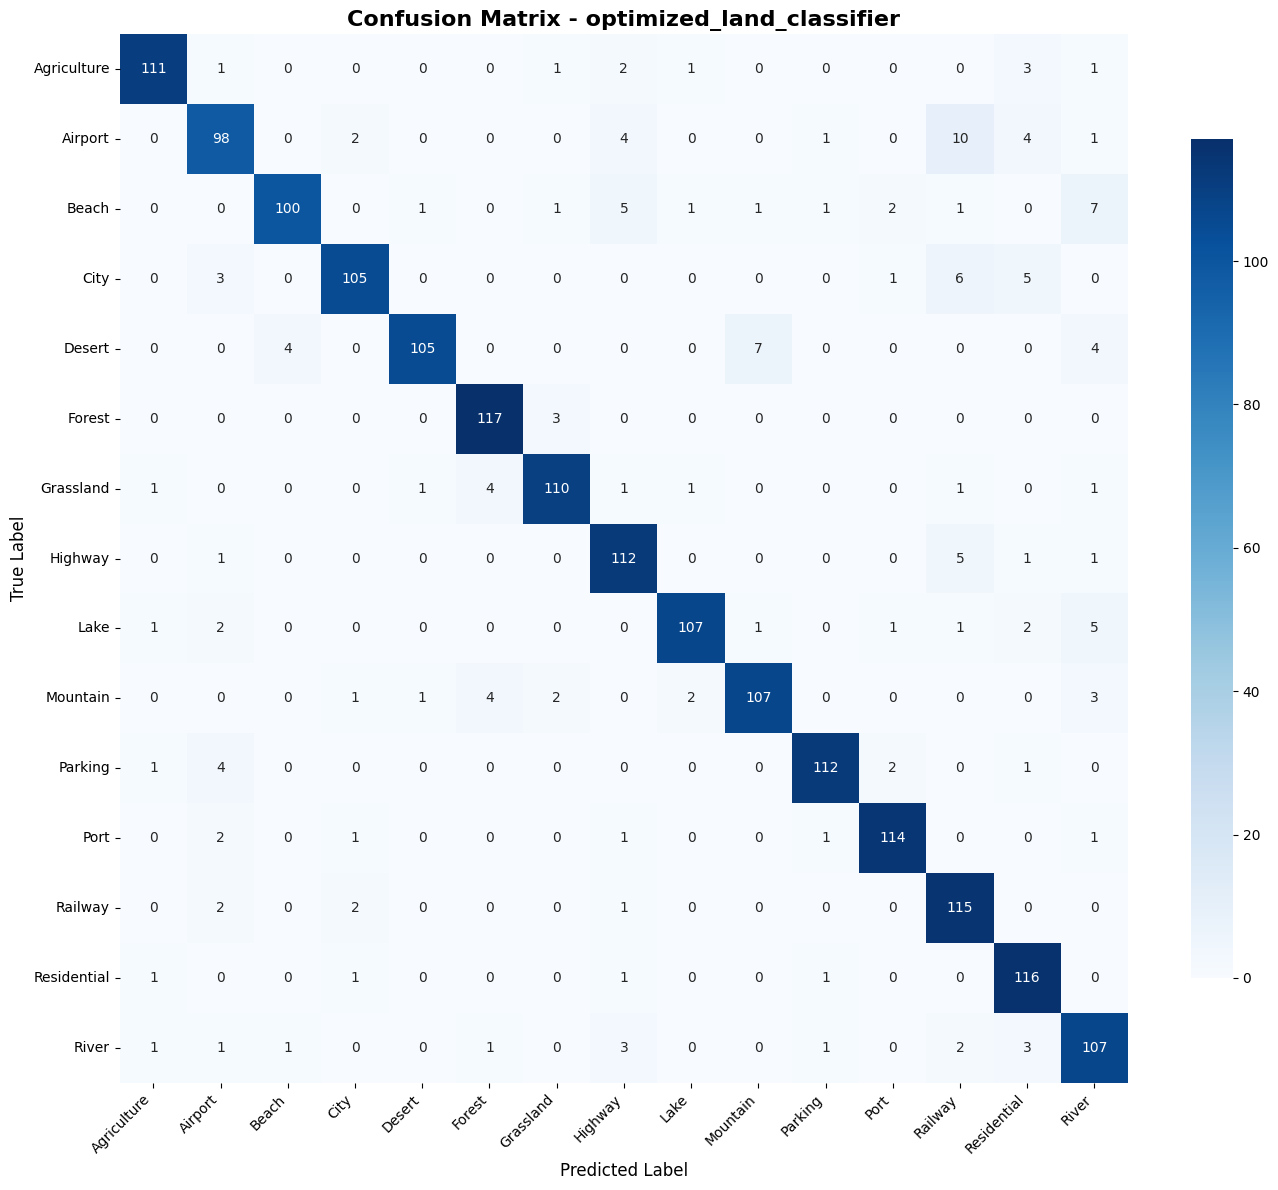

------------------------------------------------------------
CONFUSION MATRIX BERHASIL DIBUAT!
Shape confusion matrix: (15, 15)
Confusion matrix disimpan sebagai: optimized_land_classifier_confusion_matrix_fixed.png


In [32]:
# MEMBUAT PREDIKSI DAN CONFUSION MATRIX (FIXED)

def create_predictions_and_confusion_matrix_fixed(model, test_generator, class_names):
    """Create predictions and confusion matrix - FIXED VERSION"""
    print("\nMEMBUAT PREDIKSI DAN CONFUSION MATRIX - FIXED")
    print("=" * 60)
    print(f"Model: {model.name}")
    print(f"Classes: {len(class_names)}")
    print("-" * 60)

    # Reset generator
    test_generator.reset()

    # Get predictions
    print("Generating predictions...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_generator.classes

    print(f"Total predictions: {len(predicted_classes)}")
    print(f"Total true labels: {len(true_classes)}")
    print(f"Unique predicted classes: {np.unique(predicted_classes)}")
    print(f"Unique true classes: {np.unique(true_classes)}")

    # Create confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': 0.8})
    plt.title(f'Confusion Matrix - {model.name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{model.name}_confusion_matrix_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("-" * 60)
    print("CONFUSION MATRIX BERHASIL DIBUAT!")
    print(f"Shape confusion matrix: {cm.shape}")
    print(f"Confusion matrix disimpan sebagai: {model.name}_confusion_matrix_fixed.png")
    print("=" * 60)

    return predictions, predicted_classes, true_classes, cm

# RUN CONFUSION MATRIX
predictions, predicted_classes, true_classes, cm = create_predictions_and_confusion_matrix_fixed(
    model, test_gen, class_names
)



In [33]:
# CLASSIFICATION REPORT (FIXED)


def generate_classification_report_fixed(true_classes, predicted_classes, class_names, model_name):
    """Generate detailed classification report - FIXED VERSION"""
    print("\nGENERATE CLASSIFICATION REPORT - FIXED")
    print("=" * 60)
    print(f"Model: {model_name}")
    print(f"True classes range: {np.min(true_classes)} - {np.max(true_classes)}")
    print(f"Predicted classes range: {np.min(predicted_classes)} - {np.max(predicted_classes)}")
    print(f"Number of class names: {len(class_names)}")
    print("-" * 60)

    # Generate classification report
    report = classification_report(
        true_classes, predicted_classes,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Print detailed report
    report_str = classification_report(
        true_classes, predicted_classes,
        target_names=class_names,
        zero_division=0
    )

    print("CLASSIFICATION REPORT:")
    print(report_str)

    # Extract key metrics
    accuracy = report['accuracy']
    macro_avg_precision = report['macro avg']['precision']
    macro_avg_recall = report['macro avg']['recall']
    macro_avg_f1 = report['macro avg']['f1-score']

    print("-" * 60)
    print("RINGKASAN PERFORMA:")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Macro Average Precision: {macro_avg_precision:.4f}")
    print(f"Macro Average Recall: {macro_avg_recall:.4f}")
    print(f"Macro Average F1-Score: {macro_avg_f1:.4f}")
    print("=" * 60)

    return report

# RUN CLASSIFICATION REPORT
classification_report_dict = generate_classification_report_fixed(
    true_classes, predicted_classes, class_names, model.name
)




GENERATE CLASSIFICATION REPORT - FIXED
Model: optimized_land_classifier
True classes range: 0 - 14
Predicted classes range: 0 - 14
Number of class names: 15
------------------------------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Agriculture       0.96      0.93      0.94       120
     Airport       0.86      0.82      0.84       120
       Beach       0.95      0.83      0.89       120
        City       0.94      0.88      0.91       120
      Desert       0.97      0.88      0.92       120
      Forest       0.93      0.97      0.95       120
   Grassland       0.94      0.92      0.93       120
     Highway       0.86      0.93      0.90       120
        Lake       0.96      0.89      0.92       120
    Mountain       0.92      0.89      0.91       120
     Parking       0.96      0.93      0.95       120
        Port       0.95      0.95      0.95       120
     Railway       0.82      0.96      0.88       120
 


VISUALISASI TOP PREDICTIONS - FIXED
Model: optimized_land_classifier
Samples to display: 12
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


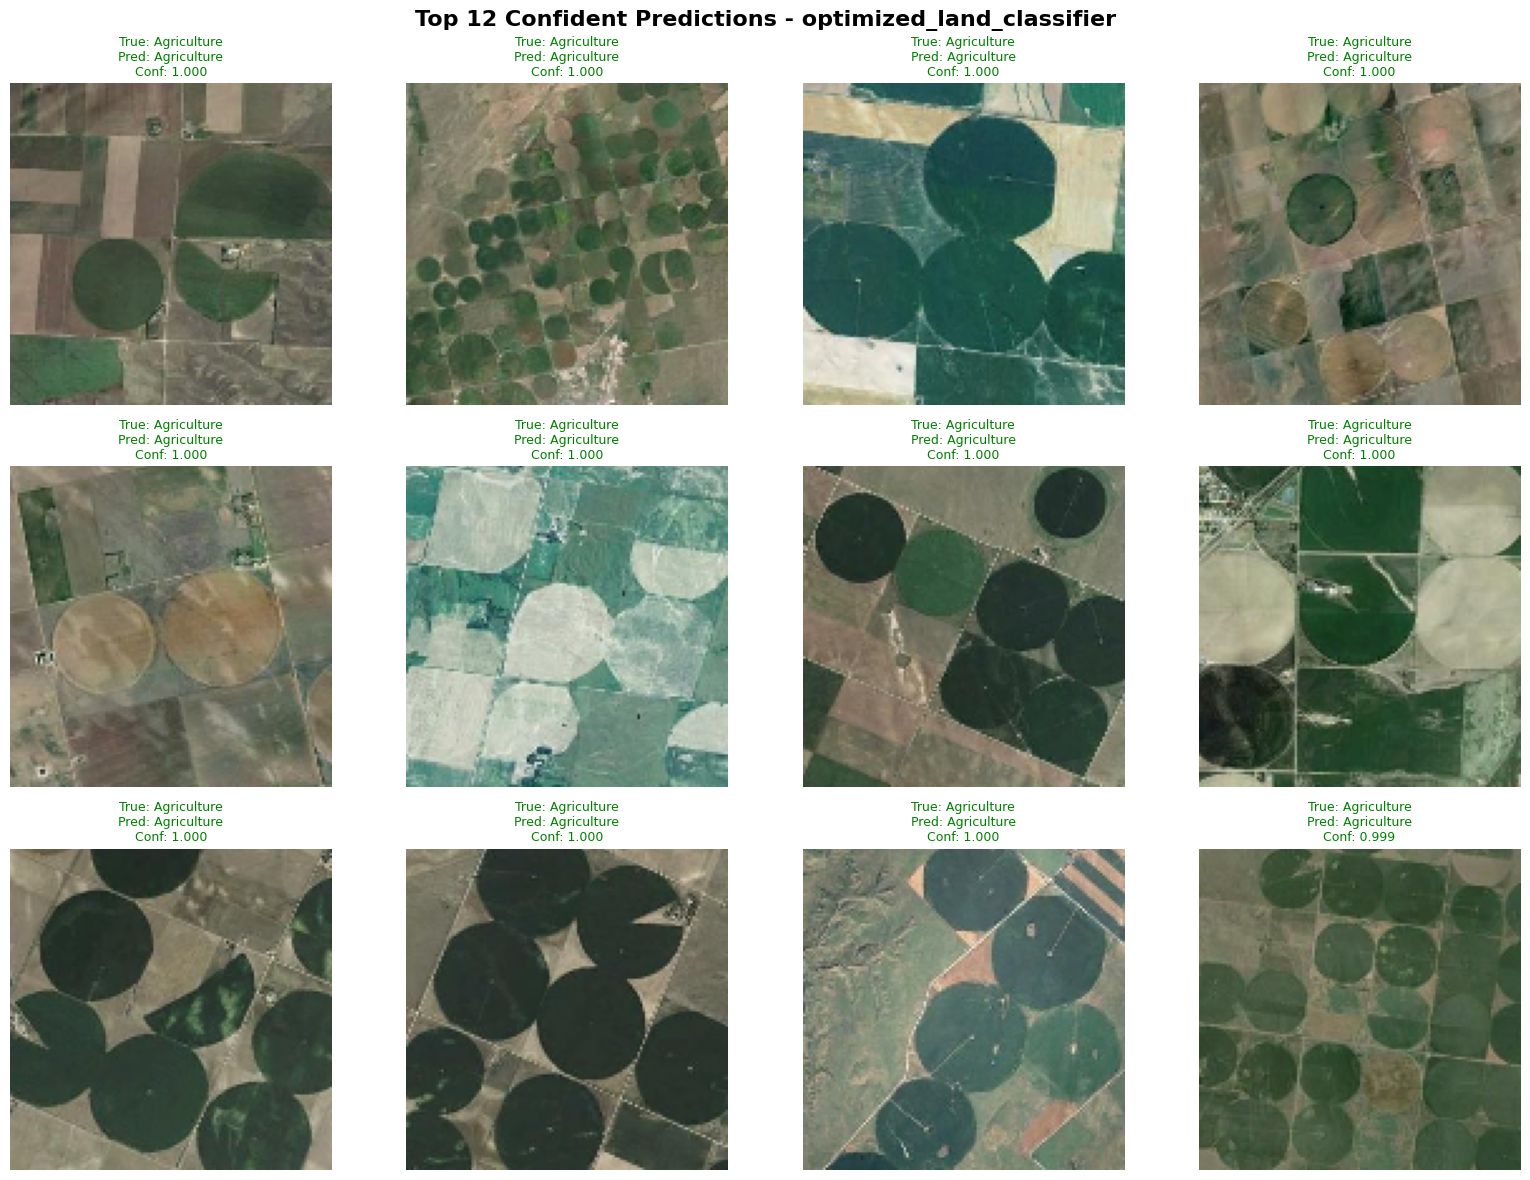

Visualisasi top predictions berhasil ditampilkan!
Gambar disimpan sebagai: optimized_land_classifier_top_predictions_fixed.png


In [34]:
# VISUALISASI TOP PREDICTIONS (FIXED)


def visualize_top_predictions_fixed(model, test_generator, class_names, num_samples=12):
    """Visualize top confident predictions - FIXED VERSION"""
    print("\nVISUALISASI TOP PREDICTIONS - FIXED")
    print("=" * 60)
    print(f"Model: {model.name}")
    print(f"Samples to display: {num_samples}")
    print("-" * 60)

    # Reset generator and get batch
    test_generator.reset()
    batch_x, batch_y = next(test_generator)

    # Get predictions
    batch_predictions = model.predict(batch_x)
    batch_predicted_classes = np.argmax(batch_predictions, axis=1)
    batch_true_classes = np.argmax(batch_y, axis=1)
    batch_confidences = np.max(batch_predictions, axis=1)

    # Sort by confidence
    confidence_indices = np.argsort(batch_confidences)[::-1][:num_samples]

    # Create visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i, idx in enumerate(confidence_indices):
        img = batch_x[idx]
        true_class = class_names[batch_true_classes[idx]]
        pred_class = class_names[batch_predicted_classes[idx]]
        confidence = batch_confidences[idx]

        # Normalize image for display
        if img.min() < 0:
            img_display = (img + 1) / 2
        else:
            img_display = img

        # Ensure values are in [0,1] range
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(
            f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
            fontsize=9,
            color='green' if true_class == pred_class else 'red'
        )
        axes[i].axis('off')

    plt.suptitle(f'Top {num_samples} Confident Predictions - {model.name}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{model.name}_top_predictions_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Visualisasi top predictions berhasil ditampilkan!")
    print(f"Gambar disimpan sebagai: {model.name}_top_predictions_fixed.png")
    print("=" * 60)

# RUN TOP PREDICTIONS
visualize_top_predictions_fixed(model, test_gen, class_names, num_samples=12)



In [35]:
# ANALISIS PER CLASS PERFORMANCE (FIXED)


def analyze_per_class_performance_fixed(cm, class_names, model_name):
    """Analyze performance per class - FIXED VERSION"""
    print("\nANALISIS PERFORMA PER CLASS - FIXED")
    print("=" * 60)
    print(f"Model: {model_name}")
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Number of classes: {len(class_names)}")
    print("-" * 60)

    # Calculate per-class metrics
    class_accuracy = []
    class_precision = []
    class_recall = []
    class_f1 = []

    for i in range(len(class_names)):
        if i < cm.shape[0]:  # Make sure class exists in confusion matrix
            # True Positives
            tp = cm[i, i]
            # False Positives
            fp = cm[:, i].sum() - tp
            # False Negatives
            fn = cm[i, :].sum() - tp
            # True Negatives
            tn = cm.sum() - tp - fp - fn

            # Calculate metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            class_accuracy.append(accuracy)
            class_precision.append(precision)
            class_recall.append(recall)
            class_f1.append(f1)

            print(f"{class_names[i]:<15} - Acc: {accuracy:.3f}, Prec: {precision:.3f}, Rec: {recall:.3f}, F1: {f1:.3f} (Samples: {tp+fn})")
        else:
            print(f"{class_names[i]:<15} - No samples in test set")

    # Find best and worst performing classes
    if class_accuracy:
        best_acc_idx = np.argmax(class_accuracy)
        worst_acc_idx = np.argmin(class_accuracy)

        print("-" * 60)
        print("PERFORMA TERBAIK DAN TERBURUK:")
        print(f"Best Performance: {class_names[best_acc_idx]} (Accuracy: {class_accuracy[best_acc_idx]:.3f})")
        print(f"Worst Performance: {class_names[worst_acc_idx]} (Accuracy: {class_accuracy[worst_acc_idx]:.3f})")
        print(f"Average Accuracy: {np.mean(class_accuracy):.3f}")
        print(f"Average Precision: {np.mean(class_precision):.3f}")
        print(f"Average Recall: {np.mean(class_recall):.3f}")
        print(f"Average F1-Score: {np.mean(class_f1):.3f}")

    print("=" * 60)

    return class_accuracy, class_precision, class_recall, class_f1

# RUN PER CLASS ANALYSIS
class_acc, class_prec, class_rec, class_f1 = analyze_per_class_performance_fixed(cm, class_names, model.name)




ANALISIS PERFORMA PER CLASS - FIXED
Model: optimized_land_classifier
Confusion matrix shape: (15, 15)
Number of classes: 15
------------------------------------------------------------
Agriculture     - Acc: 0.992, Prec: 0.957, Rec: 0.925, F1: 0.941 (Samples: 120)
Airport         - Acc: 0.979, Prec: 0.860, Rec: 0.817, F1: 0.838 (Samples: 120)
Beach           - Acc: 0.986, Prec: 0.952, Rec: 0.833, F1: 0.889 (Samples: 120)
City            - Acc: 0.988, Prec: 0.938, Rec: 0.875, F1: 0.905 (Samples: 120)
Desert          - Acc: 0.990, Prec: 0.972, Rec: 0.875, F1: 0.921 (Samples: 120)
Forest          - Acc: 0.993, Prec: 0.929, Rec: 0.975, F1: 0.951 (Samples: 120)
Grassland       - Acc: 0.991, Prec: 0.940, Rec: 0.917, F1: 0.928 (Samples: 120)
Highway         - Acc: 0.986, Prec: 0.862, Rec: 0.933, F1: 0.896 (Samples: 120)
Lake            - Acc: 0.990, Prec: 0.955, Rec: 0.892, F1: 0.922 (Samples: 120)
Mountain        - Acc: 0.988, Prec: 0.922, Rec: 0.892, F1: 0.907 (Samples: 120)
Parking       


VISUALISASI TRAINING HISTORY - FIXED
Model: LandClassifier_Fixed
Include: Initial training + Fine-tuning
------------------------------------------------------------


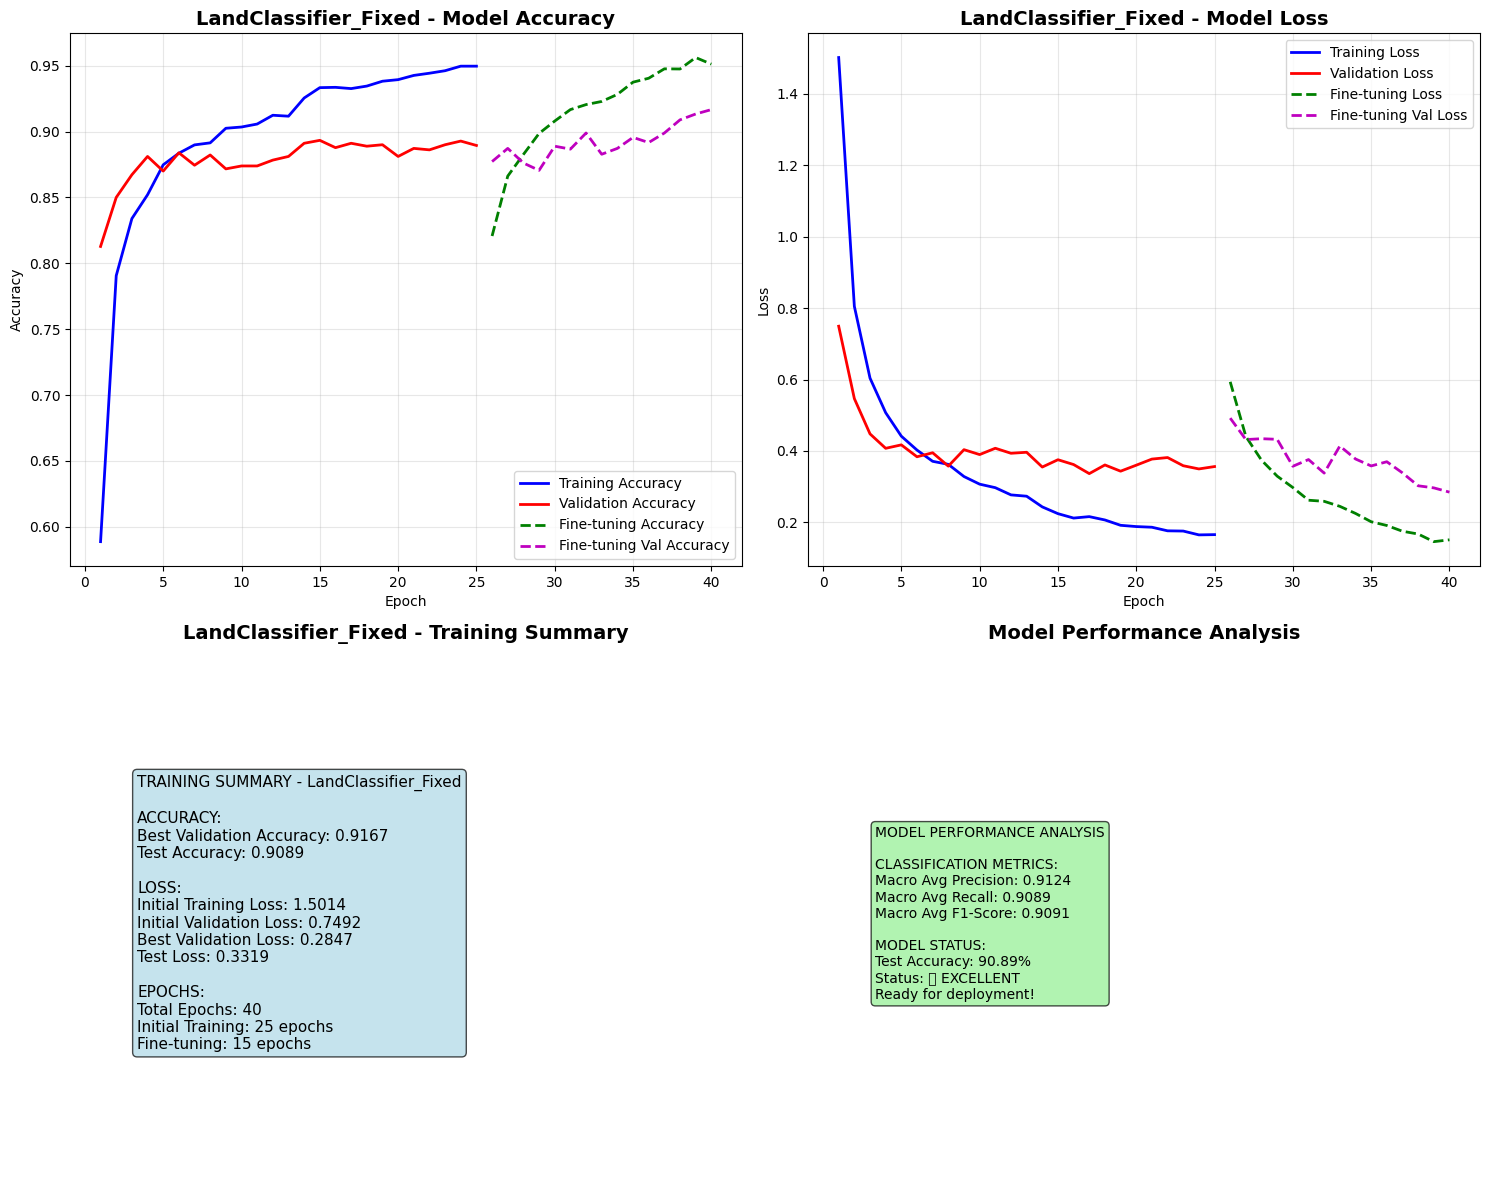

Grafik training history berhasil ditampilkan!
Grafik disimpan sebagai: LandClassifier_Fixed_training_history_fixed.png


In [36]:
# PLOT TRAINING HISTORY (FIXED)


def plot_training_history_fixed(history, fine_tuning_history=None, model_name="Model"):
    """Plot training and validation accuracy/loss curves - FIXED VERSION"""
    print(f"\nVISUALISASI TRAINING HISTORY - FIXED")
    print("=" * 60)
    print(f"Model: {model_name}")

    if fine_tuning_history:
        print("Include: Initial training + Fine-tuning")
    else:
        print("Include: Initial training only")
    print("-" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Get training metrics
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy
    axes[0,0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0,0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)

    # Plot training & validation loss
    axes[0,1].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0,1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

    # If fine-tuning was performed, add those results
    if fine_tuning_history:
        ft_epochs = range(len(history.history['accuracy']) + 1,
                         len(history.history['accuracy']) + len(fine_tuning_history.history['accuracy']) + 1)

        axes[0,0].plot(ft_epochs, fine_tuning_history.history['accuracy'], 'g--',
                       label='Fine-tuning Accuracy', linewidth=2)
        axes[0,0].plot(ft_epochs, fine_tuning_history.history['val_accuracy'], 'm--',
                       label='Fine-tuning Val Accuracy', linewidth=2)

        axes[0,1].plot(ft_epochs, fine_tuning_history.history['loss'], 'g--',
                       label='Fine-tuning Loss', linewidth=2)
        axes[0,1].plot(ft_epochs, fine_tuning_history.history['val_loss'], 'm--',
                       label='Fine-tuning Val Loss', linewidth=2)

    # Customize accuracy plot
    axes[0,0].set_title(f'{model_name} - Model Accuracy', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Customize loss plot
    axes[0,1].set_title(f'{model_name} - Model Loss', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Summary statistics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    initial_loss = history.history['loss'][0]
    initial_val_loss = history.history['val_loss'][0]
    total_epochs = len(epochs)

    if fine_tuning_history:
        ft_best_val_acc = max(fine_tuning_history.history['val_accuracy'])
        ft_best_val_loss = min(fine_tuning_history.history['val_loss'])
        best_val_acc = max(best_val_acc, ft_best_val_acc)
        best_val_loss = min(best_val_loss, ft_best_val_loss)
        total_epochs += len(fine_tuning_history.history['accuracy'])

    summary_text = f"""TRAINING SUMMARY - {model_name}

ACCURACY:
Best Validation Accuracy: {best_val_acc:.4f}
Test Accuracy: {test_accuracy:.4f}

LOSS:
Initial Training Loss: {initial_loss:.4f}
Initial Validation Loss: {initial_val_loss:.4f}
Best Validation Loss: {best_val_loss:.4f}
Test Loss: {test_loss:.4f}

EPOCHS:
Total Epochs: {total_epochs}
Initial Training: {len(epochs)} epochs"""

    if fine_tuning_history:
        summary_text += f"""
Fine-tuning: {len(fine_tuning_history.history['accuracy'])} epochs"""

    axes[1,0].text(0.1, 0.5, summary_text, transform=axes[1,0].transAxes,
                   fontsize=11, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    axes[1,0].set_title(f'{model_name} - Training Summary', fontsize=14, fontweight='bold')
    axes[1,0].axis('off')

    # Model performance analysis
    performance_text = f"""MODEL PERFORMANCE ANALYSIS

CLASSIFICATION METRICS:
Macro Avg Precision: {classification_report_dict['macro avg']['precision']:.4f}
Macro Avg Recall: {classification_report_dict['macro avg']['recall']:.4f}
Macro Avg F1-Score: {classification_report_dict['macro avg']['f1-score']:.4f}

MODEL STATUS:
Test Accuracy: {test_accuracy*100:.2f}%
"""
    if test_accuracy >= 0.9:
        performance_text += "Status: 🟢 EXCELLENT\nReady for deployment!"
    elif test_accuracy >= 0.8:
        performance_text += "Status: 🟡 GOOD\nReady for deployment"
    elif test_accuracy >= 0.7:
        performance_text += "Status: 🟠 FAIR\nNeeds improvement"
    else:
        performance_text += "Status: 🔴 POOR\nNeeds retraining"

    axes[1,1].text(0.1, 0.5, performance_text, transform=axes[1,1].transAxes,
                   fontsize=10, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    axes[1,1].set_title('Model Performance Analysis', fontsize=14, fontweight='bold')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik training history berhasil ditampilkan!")
    print(f"Grafik disimpan sebagai: {model_name}_training_history_fixed.png")
    print("=" * 60)

# RUN PLOT TRAINING HISTORY
plot_training_history_fixed(history, fine_tuning_history=history_ft, model_name="LandClassifier_Fixed")



In [37]:
# FINAL SUMMARY (FIXED)


def create_final_summary_fixed():
    """Create final comprehensive summary"""
    print("\n" + "="*80)
    print("🏁 EVALUASI DAN VISUALISASI SELESAI 🏁")
    print("="*80)
    print(f"✅ Model: {model.name}")
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"✅ Test Loss: {test_loss:.4f}")
    print(f"✅ Total Classes: {len(class_names)}")
    print(f"✅ Test Samples: {test_gen.samples}")
    print("-"*80)

    print("\n📊 PERFORMANCE METRICS:")
    print(f"   • Macro Avg Precision: {classification_report_dict['macro avg']['precision']:.4f}")
    print(f"   • Macro Avg Recall: {classification_report_dict['macro avg']['recall']:.4f}")
    print(f"   • Macro Avg F1-Score: {classification_report_dict['macro avg']['f1-score']:.4f}")

    print("\n📁 FILES GENERATED:")
    print(f"   • {model.name}_confusion_matrix_fixed.png")
    print(f"   • {model.name}_top_predictions_fixed.png")
    print(f"   • LandClassifier_Fixed_training_history_fixed.png")

    if test_accuracy >= 0.9:
        status = "🟢 EXCELLENT - Ready for deployment!"
    elif test_accuracy >= 0.8:
        status = "🟡 GOOD - Ready for deployment"
    elif test_accuracy >= 0.7:
        status = "🟠 FAIR - Consider improvement"
    else:
        status = "🔴 NEEDS IMPROVEMENT - Requires retraining"

    print(f"\n🎯 MODEL STATUS: {status}")
    print("="*80)

# RUN FINAL SUMMARY
create_final_summary_fixed()


🏁 EVALUASI DAN VISUALISASI SELESAI 🏁
✅ Model: optimized_land_classifier
✅ Test Accuracy: 0.9089 (90.89%)
✅ Test Loss: 0.3319
✅ Total Classes: 15
✅ Test Samples: 1800
--------------------------------------------------------------------------------

📊 PERFORMANCE METRICS:
   • Macro Avg Precision: 0.9124
   • Macro Avg Recall: 0.9089
   • Macro Avg F1-Score: 0.9091

📁 FILES GENERATED:
   • optimized_land_classifier_confusion_matrix_fixed.png
   • optimized_land_classifier_top_predictions_fixed.png
   • LandClassifier_Fixed_training_history_fixed.png

🎯 MODEL STATUS: 🟢 EXCELLENT - Ready for deployment!


In [40]:
# ============================================================
# CELL 8: FINAL SUMMARY WITH MODEL SAVE (ENHANCED)
# ============================================================

def create_final_summary_enhanced():
    """Create final comprehensive summary with model save and path info"""
    print("\n" + "="*80)
    print("💾 SAVING FINAL MODEL...")
    print("="*80)

    # Import time for timestamp
    import time

    # Save the final model
    model_save_path = "finish_model.keras"
    try:
        model.save(model_save_path)
        print(f"✅ Model berhasil disimpan: {model_save_path}")

        # Get model file size
        import os
        model_size = os.path.getsize(model_save_path)
        model_size_mb = model_size / (1024 * 1024)
        print(f"📁 Ukuran file model: {model_size_mb:.2f} MB")

    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return

    print("\n" + "="*80)
    print("🏁 EVALUASI DAN VISUALISASI SELESAI 🏁")
    print("="*80)
    print(f"✅ Model: {model.name}")
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"✅ Test Loss: {test_loss:.4f}")
    print(f"✅ Total Classes: {len(class_names)}")
    print(f"✅ Test Samples: {test_gen.samples}")
    print("-"*80)

    print("\n📊 PERFORMANCE METRICS:")
    print(f"   • Macro Avg Precision: {classification_report_dict['macro avg']['precision']:.4f}")
    print(f"   • Macro Avg Recall: {classification_report_dict['macro avg']['recall']:.4f}")
    print(f"   • Macro Avg F1-Score: {classification_report_dict['macro avg']['f1-score']:.4f}")

    print("\n🔧 MODEL ARCHITECTURE INFO:")
    print(f"   • Base Model: {model.layers[0].name if len(model.layers) > 0 else 'Unknown'}")
    print(f"   • Total Parameters: {model.count_params():,}")
    print(f"   • Trainable Parameters: {sum([layer.count_params() for layer in model.layers if layer.trainable]):,}")
    print(f"   • Input Shape: {model.input_shape}")
    print(f"   • Output Shape: {model.output_shape}")

    print("\n📋 CLASS INFORMATION:")
    print(f"   • Total Classes: {len(class_names)}")
    print(f"   • Classes: {', '.join(class_names[:5])}{'...' if len(class_names) > 5 else ''}")

    print("\n📁 FILES GENERATED:")
    print(f"   • {model.name}_confusion_matrix_fixed.png")
    print(f"   • {model.name}_top_predictions_fixed.png")
    print(f"   • LandClassifier_Fixed_training_history_fixed.png")
    print(f"   • finish_model.keras (SAVED MODEL)")

    print("\n📂 MODEL PATH INFORMATION:")
    print("   ─────────────────────────────────────")
    import os
    current_path = os.getcwd()
    full_model_path = os.path.join(current_path, model_save_path)

    print(f"   📁 Current Working Directory: {current_path}")
    print(f"   💾 Model Filename: {model_save_path}")
    print(f"   🔗 Full Model Path: {full_model_path}")
    print(f"   📏 File Size: {model_size_mb:.2f} MB")
    print(f"   ⏰ Save Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Check if file exists
    if os.path.exists(full_model_path):
        print(f"   ✅ File Status: EXISTS")
        print(f"   🔒 File Permissions: {oct(os.stat(full_model_path).st_mode)[-3:]}")
    else:
        print(f"   ❌ File Status: NOT FOUND")

    print("\n   📋 HOW TO LOAD MODEL:")
    print(f"   • Python: model = tf.keras.models.load_model('{model_save_path}')")
    print(f"   • Full Path: model = tf.keras.models.load_model(r'{full_model_path}')")

    if test_accuracy >= 0.9:
        status = "🟢 EXCELLENT - Ready for deployment!"
        recommendation = "Model siap untuk production deployment"
    elif test_accuracy >= 0.8:
        status = "🟡 GOOD - Ready for deployment"
        recommendation = "Model dapat digunakan dengan monitoring"
    elif test_accuracy >= 0.7:
        status = "🟠 FAIR - Consider improvement"
        recommendation = "Pertimbangkan data augmentation atau fine-tuning"
    else:
        status = "🔴 NEEDS IMPROVEMENT - Requires retraining"
        recommendation = "Model memerlukan retraining dengan data lebih banyak"

    print(f"\n🎯 MODEL STATUS: {status}")
    print(f"💡 RECOMMENDATION: {recommendation}")

    print("\n🚀 DEPLOYMENT READY:")
    print(f"   • Model file: finish_model.keras ({model_size_mb:.2f} MB)")
    print(f"   • Load dengan: tensorflow.keras.models.load_model('finish_model.keras')")
    print(f"   • Input shape: {model.input_shape}")
    print(f"   • Output classes: {len(class_names)} categories")

    print("="*80)
    print("🎉 EVALUASI LENGKAP !")
    print("="*80)

# RUN ENHANCED FINAL SUMMARY
create_final_summary_enhanced()


💾 SAVING FINAL MODEL...
✅ Model berhasil disimpan: finish_model.keras
📁 Ukuran file model: 36.26 MB

🏁 EVALUASI DAN VISUALISASI SELESAI 🏁
✅ Model: optimized_land_classifier
✅ Test Accuracy: 0.9089 (90.89%)
✅ Test Loss: 0.3319
✅ Total Classes: 15
✅ Test Samples: 1800
--------------------------------------------------------------------------------

📊 PERFORMANCE METRICS:
   • Macro Avg Precision: 0.9124
   • Macro Avg Recall: 0.9089
   • Macro Avg F1-Score: 0.9091

🔧 MODEL ARCHITECTURE INFO:
   • Base Model: mobilenetv2_1.00_128
   • Total Parameters: 3,817,487
   • Trainable Parameters: 3,817,487
   • Input Shape: (None, 128, 128, 3)
   • Output Shape: (None, 15)

📋 CLASS INFORMATION:
   • Total Classes: 15
   • Classes: Agriculture, Airport, Beach, City, Desert...

📁 FILES GENERATED:
   • optimized_land_classifier_confusion_matrix_fixed.png
   • optimized_land_classifier_top_predictions_fixed.png
   • LandClassifier_Fixed_training_history_fixed.png
   • finish_model.keras (SAVED MODEL

## Konversi Model

In [42]:
# CONVERT MODEL

def save_finish_model(model, model_path='finish_model.keras'):
    """Save the final trained model in Keras format"""
    print(f"\nMENYIMPAN FINISH MODEL")
    print("=" * 60)
    print(f"Model name: {model.name}")
    print(f"Model path: {model_path}")
    print("-" * 60)

    try:
        # Ensure we use .keras extension for native Keras format
        if not model_path.endswith('.keras'):
            model_path = model_path.replace('.h5', '.keras')
            if not model_path.endswith('.keras'):
                model_path += '.keras'

        # Save model
        model.save(model_path)

        # Save model architecture as JSON
        model_json = model.to_json()
        json_path = model_path.replace('.keras', '_architecture.json')
        with open(json_path, 'w') as json_file:
            json_file.write(model_json)

        print("HASIL PENYIMPANAN:")
        print(f"   - Model file: {model_path}")
        print(f"   - Architecture file: {json_path}")
        print(f"   - Model parameters: {model.count_params():,}")
        print(f"   - Input shape: {model.input_shape}")
        print(f"   - Output shape: {model.output_shape}")
        print("Model berhasil disimpan!")
        print("=" * 60)
        return True

    except Exception as e:
        print(f"ERROR menyimpan model: {e}")
        print("=" * 60)
        return False

def convert_to_savedmodel(finish_model_path='finish_model.keras', output_dir='finish_model_savedmodel'):
    """Convert finish_model.keras to SavedModel format"""
    print(f"\nCONVERT TO SAVEDMODEL FORMAT")
    print("=" * 60)
    print(f"Source: {finish_model_path}")
    print(f"Output directory: {output_dir}")
    print("-" * 60)

    try:
        start_time = time.time()

        # Load the Keras model
        print("Loading finish_model.keras...")
        model = tf.keras.models.load_model(finish_model_path)
        print(f"Model loaded successfully: {model.name}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Save as SavedModel using tf.saved_model.save
        print("Converting to SavedModel format...")
        tf.saved_model.save(model, output_dir)

        end_time = time.time()
        conversion_time = end_time - start_time

        print("KONVERSI BERHASIL:")
        print(f"   - SavedModel directory: {output_dir}")
        print(f"   - Conversion time: {conversion_time:.2f} seconds")
        print(f"   - Model signature: Default serving signature")
        print("SavedModel berhasil dibuat!")
        print("=" * 60)
        return output_dir

    except Exception as e:
        print(f"ERROR convert ke SavedModel: {e}")
        print("=" * 60)
        return None

def convert_to_tflite(finish_model_path='finish_model.keras', output_dir='finish_model_tflite'):
    """Convert finish_model.keras to TensorFlow Lite format"""
    print(f"\nCONVERT TO TFLITE FORMAT")
    print("=" * 60)
    print(f"Source: {finish_model_path}")
    print(f"Output directory: {output_dir}")
    print("-" * 60)

    try:
        start_time = time.time()

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Load the Keras model
        print("Loading finish_model.keras...")
        model = tf.keras.models.load_model(finish_model_path)
        print(f"Model loaded successfully: {model.name}")

        # Convert to TensorFlow Lite with optimizations
        print("Converting to TFLite format...")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # Configure converter settings
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter.allow_custom_ops = True

        # Convert model
        tflite_model = converter.convert()

        # Save the TFLite model
        tflite_path = os.path.join(output_dir, 'finish_model.tflite')
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)

        end_time = time.time()
        conversion_time = end_time - start_time

        # Get model size
        model_size = os.path.getsize(tflite_path) / (1024 * 1024)  # Size in MB

        print("KONVERSI BERHASIL:")
        print(f"   - TFLite model: {tflite_path}")
        print(f"   - Model size: {model_size:.2f} MB")
        print(f"   - Conversion time: {conversion_time:.2f} seconds")
        print(f"   - Optimizations: DEFAULT")
        print("TFLite model berhasil dibuat!")
        print("=" * 60)
        return tflite_path

    except Exception as e:
        print(f"ERROR convert ke TFLite: {e}")
        print("=" * 60)
        return None

def create_label_file(class_names, output_dir='finish_model_tflite'):
    """Create label.txt file for TFLite model"""
    print(f"\nMEMBUAT LABEL FILE")
    print("=" * 60)
    print(f"Output directory: {output_dir}")
    print(f"Number of classes: {len(class_names)}")
    print("-" * 60)

    try:
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Save labels
        label_path = os.path.join(output_dir, 'labels.txt')
        with open(label_path, 'w', encoding='utf-8') as f:
            for i, label in enumerate(class_names):
                f.write(f"{label}\n")

        print("LABEL FILE BERHASIL DIBUAT:")
        print(f"   - Label file: {label_path}")
        print(f"   - Total classes: {len(class_names)}")
        print("Classes:")
        for i, label in enumerate(class_names):
            print(f"     {i}: {label}")
        print("Label file berhasil dibuat!")
        print("=" * 60)
        return label_path

    except Exception as e:
        print(f"ERROR membuat label file: {e}")
        print("=" * 60)
        return None

def convert_to_tfjs(finish_model_path='finish_model.keras', output_dir='finish_model_tfjs'):
    """Convert finish_model.keras to TensorFlow.js format"""
    print(f"\nCONVERT TO TFJS FORMAT")
    print("=" * 60)
    print(f"Source: {finish_model_path}")
    print(f"Output directory: {output_dir}")
    print("-" * 60)

    try:
        start_time = time.time()

        # Check and install tensorflowjs if not available
        try:
            import tensorflowjs as tfjs
            print("TensorFlow.js converter available")
        except ImportError:
            print("Installing tensorflowjs...")
            import subprocess
            import sys
            subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflowjs"])
            import tensorflowjs as tfjs
            print("TensorFlow.js converter installed successfully")

        # Load the Keras model
        print("Loading finish_model.keras...")
        model = tf.keras.models.load_model(finish_model_path)
        print(f"Model loaded successfully: {model.name}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Convert to TensorFlow.js
        print("Converting to TensorFlow.js format...")
        tfjs.converters.save_keras_model(model, output_dir)

        end_time = time.time()
        conversion_time = end_time - start_time

        # Check generated files
        generated_files = os.listdir(output_dir)
        model_json = [f for f in generated_files if f.endswith('.json')]
        model_weights = [f for f in generated_files if f.endswith('.bin')]

        print("KONVERSI BERHASIL:")
        print(f"   - TFJS directory: {output_dir}")
        print(f"   - Model JSON: {len(model_json)} file(s)")
        print(f"   - Weight files: {len(model_weights)} file(s)")
        print(f"   - Conversion time: {conversion_time:.2f} seconds")
        print("TensorFlow.js model berhasil dibuat!")
        print("=" * 60)
        return output_dir

    except Exception as e:
        print(f"ERROR convert ke TensorFlow.js: {e}")
        print("Solusi: pip install --upgrade tensorflowjs")
        print("=" * 60)
        return None

def convert_all_formats(finish_model_path='finish_model.keras', class_names=None):
    """Convert finish_model to all formats and display summary"""
    print(f"\nCONVERT ALL FORMATS - FINISH MODEL")
    print("=" * 80)
    print(f"Source model: {finish_model_path}")
    print(f"Converting to: SavedModel, TFLite, TensorFlow.js")
    print("=" * 80)

    conversion_results = {
        'savedmodel_path': None,
        'tflite_path': None,
        'tfjs_path': None,
        'labels_path': None
    }

    total_start_time = time.time()

    # Convert to SavedModel
    savedmodel_path = convert_to_savedmodel(finish_model_path, 'finish_model_savedmodel')
    conversion_results['savedmodel_path'] = savedmodel_path

    # Convert to TFLite
    tflite_path = convert_to_tflite(finish_model_path, 'finish_model_tflite')
    conversion_results['tflite_path'] = tflite_path

    # Create label file
    if class_names and tflite_path:
        labels_path = create_label_file(class_names, 'finish_model_tflite')
        conversion_results['labels_path'] = labels_path

    # Convert to TensorFlow.js
    tfjs_path = convert_to_tfjs(finish_model_path, 'finish_model_tfjs')
    conversion_results['tfjs_path'] = tfjs_path

    total_end_time = time.time()
    total_conversion_time = total_end_time - total_start_time

    # Display final summary
    print(f"\nCONVERSION SUMMARY - FINISH MODEL")
    print("=" * 80)
    print(f"Total conversion time: {total_conversion_time:.2f} seconds")
    print(f"Total conversion time: {total_conversion_time/60:.2f} minutes")
    print("-" * 80)

    print("CONVERTED MODEL PATHS:")
    success_count = 0

    if conversion_results['savedmodel_path']:
        print(f"   SavedModel    : {conversion_results['savedmodel_path']}")
        success_count += 1
    else:
        print(f"   SavedModel    : FAILED")

    if conversion_results['tflite_path']:
        print(f"   TFLite        : {conversion_results['tflite_path']}")
        success_count += 1
    else:
        print(f"   TFLite        : FAILED")

    if conversion_results['labels_path']:
        print(f"   Labels        : {conversion_results['labels_path']}")

    if conversion_results['tfjs_path']:
        print(f"   TensorFlow.js : {conversion_results['tfjs_path']}")
        success_count += 1
    else:
        print(f"   TensorFlow.js : FAILED")

    print("-" * 80)
    print(f"CONVERSION STATUS: {success_count}/3 formats successfully converted")

    if success_count == 3:
        print("STATUS: ALL CONVERSIONS SUCCESSFUL!")
        print("Models ready for deployment on different platforms")
    elif success_count >= 2:
        print("STATUS: MOSTLY SUCCESSFUL!")
        print("Most conversions completed successfully")
    else:
        print("STATUS: MULTIPLE FAILURES!")
        print("Check error messages above for troubleshooting")

    print("=" * 80)

    return conversion_results

# Convert all formats
conversion_results = convert_all_formats('finish_model.keras', class_names)

# Individual conversions
# savedmodel_path = convert_to_savedmodel('finish_model.keras')
# tflite_path = convert_to_tflite('finish_model.keras')
# labels_path = create_label_file(class_names)
# tfjs_path = convert_to_tfjs('finish_model.keras')


CONVERT ALL FORMATS - FINISH MODEL
Source model: finish_model.keras
Converting to: SavedModel, TFLite, TensorFlow.js

CONVERT TO SAVEDMODEL FORMAT
Source: finish_model.keras
Output directory: finish_model_savedmodel
------------------------------------------------------------
Loading finish_model.keras...
Model loaded successfully: optimized_land_classifier
Converting to SavedModel format...
KONVERSI BERHASIL:
   - SavedModel directory: finish_model_savedmodel
   - Conversion time: 12.03 seconds
   - Model signature: Default serving signature
SavedModel berhasil dibuat!

CONVERT TO TFLITE FORMAT
Source: finish_model.keras
Output directory: finish_model_tflite
------------------------------------------------------------
Loading finish_model.keras...
Model loaded successfully: optimized_land_classifier
Converting to TFLite format...
Saved artifact at '/tmp/tmpjg3aezn7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 12

TensorFlow.js converter installed successfully
Loading finish_model.keras...


Model loaded successfully: optimized_land_classifier
Converting to TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
KONVERSI BERHASIL:
   - TFJS directory: finish_model_tfjs
   - Model JSON: 1 file(s)
   - Weight files: 4 file(s)
   - Conversion time: 9.92 seconds
TensorFlow.js model berhasil dibuat!

CONVERSION SUMMARY - FINISH MODEL
Total conversion time: 39.60 seconds
Total conversion time: 0.66 minutes
--------------------------------------------------------------------------------
CONVERTED MODEL PATHS:
   SavedModel    : finish_model_savedmodel
   TFLite        : finish_model_tflite/finish_model.tflite
   Labels        : finish_model_tflite/labels.txt
   TensorFlow.js : finish_model_tfjs
--------------------------------------------------------------------------------
CONVERSION STATUS: 3/3 formats successfully converted
STATUS: ALL CONVERSIONS SUCCESSFUL!
Models ready for deployment on different platforms


## Inference (Optional)

LAND CLASSIFICATION BATCH INFERENCE (TFLITE)

LOADING TFLITE MODEL FOR BATCH INFERENCE
Model berhasil dimuat dari: finish_model_tflite/finish_model.tflite
Input shape: [  1 128 128   3]
Output shape: [ 1 15]
Input dtype: <class 'numpy.float32'>
Output dtype: <class 'numpy.float32'>

LOADING CLASS LABELS
Labels berhasil dimuat dari: finish_model_tflite/labels.txt
Total kelas: 15
Daftar kelas:
  0: Agriculture
  1: Airport
  2: Beach
  3: City
  4: Desert
  5: Forest
  6: Grassland
  7: Highway
  8: Lake
  9: Mountain
  10: Parking
  11: Port
  12: Railway
  13: Residential
  14: River
Test directory ditemukan: /content/dataset_split/test
Jumlah kelas ditemukan: 15
Kelas: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

LOADING REAL TEST IMAGES
Berhasil memuat 30 gambar test
Shape images: (30, 128, 128, 3)
Shape labels: (30, 15)
Menggunakan gambar test ASLI dari dataset
Total

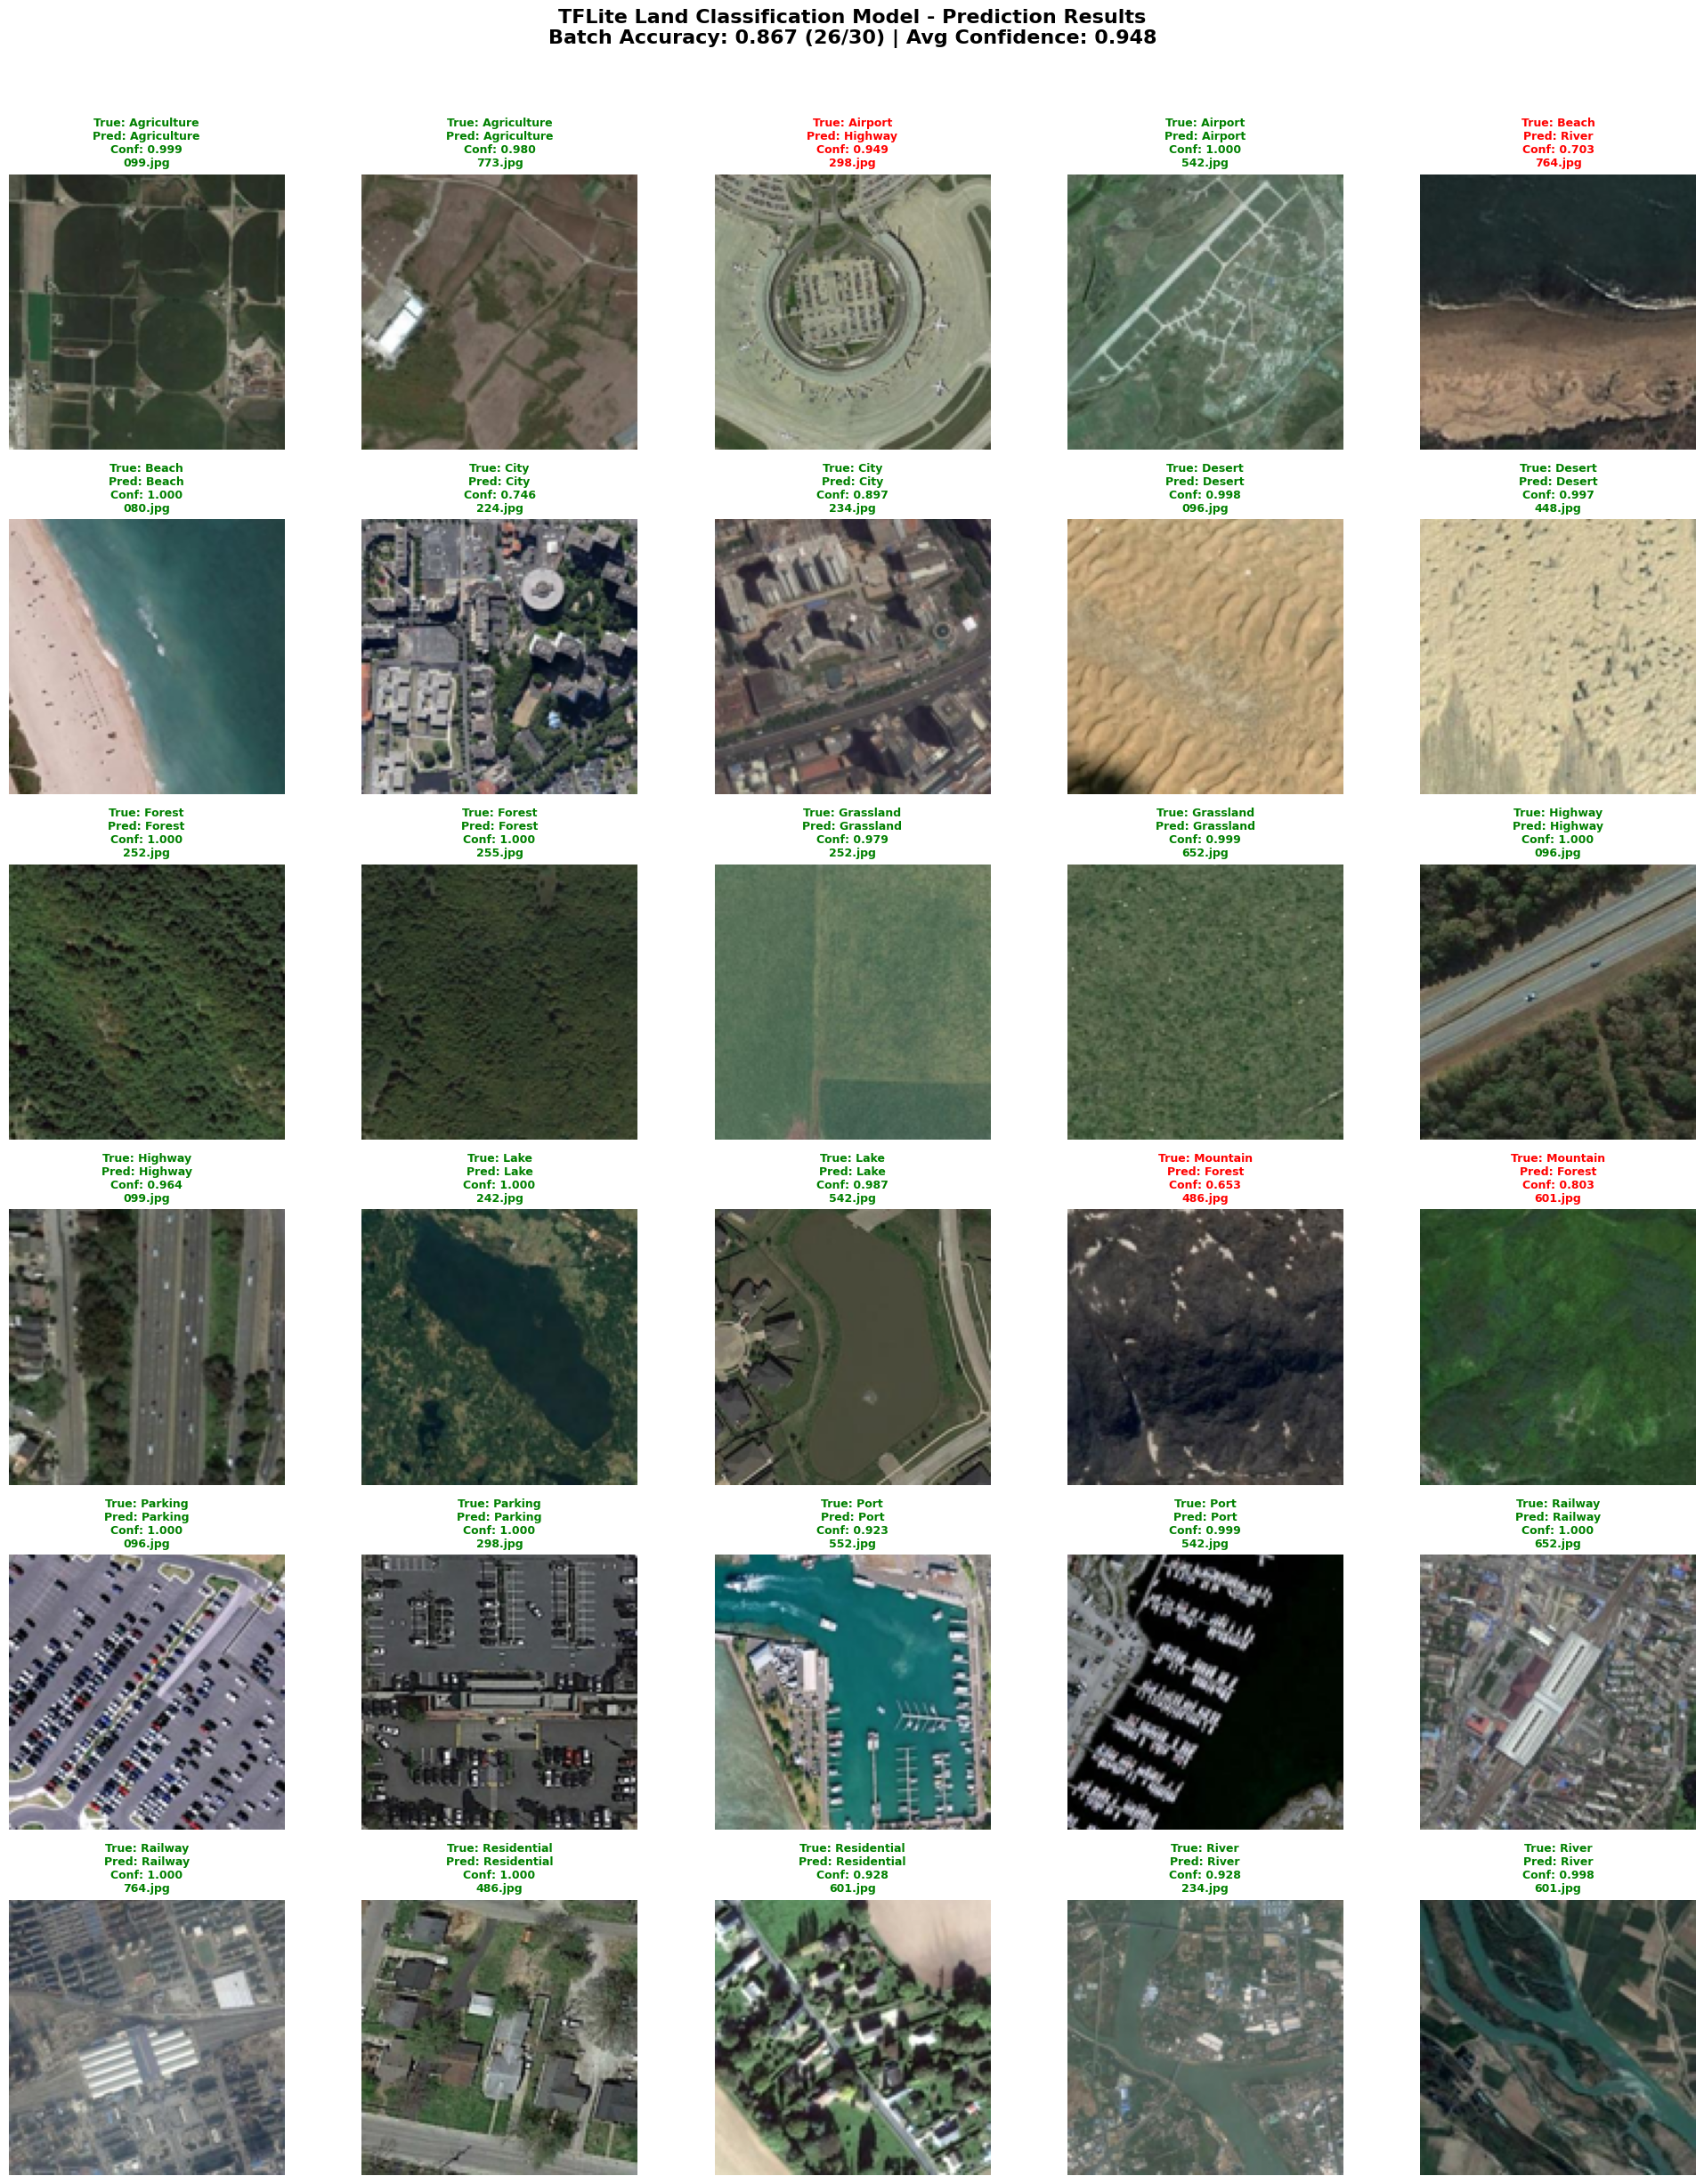


DETAILED PREDICTION SUMMARY
Total samples: 30
Correct predictions: 26
Batch accuracy: 0.867
Average confidence: 0.948
Min confidence: 0.653
Max confidence: 1.000

PREDICTION DISTRIBUTION
Agriculture: 2 predictions
Airport: 1 predictions
Beach: 1 predictions
City: 2 predictions
Desert: 2 predictions
Forest: 4 predictions
Grassland: 2 predictions
Highway: 3 predictions
Lake: 2 predictions
Parking: 2 predictions
Port: 2 predictions
Railway: 2 predictions
Residential: 2 predictions
River: 3 predictions

BATCH INFERENCE SELESAI
HASIL DENGAN DATASET LAND CLASSIFICATION:
   - Menggunakan format TFLite untuk inference
   - 15 kategori klasifikasi lahan
   - Struktur: dataset_split/test/
   - Akurasi yang ditampilkan adalah performance model TFLite

INTERPRETASI HASIL:
   - Akurasi > 80%: Model sangat baik
   - Akurasi 60-80%: Model cukup baik
   - Akurasi < 60%: Model perlu improvement


In [47]:
# Inference
def load_tflite_model(model_path='finish_model_tflite/finish_model.tflite'):
    """Load TFLite model for inference"""
    print("\nLOADING TFLITE MODEL FOR BATCH INFERENCE")
    print("=" * 60)

    try:
        # Try different TFLite model paths
        possible_paths = [
            model_path,
            'finish_model_tflite/finish_model.tflite',
            'finish_model.tflite'
        ]

        interpreter = None
        for path in possible_paths:
            if os.path.exists(path):
                interpreter = tf.lite.Interpreter(model_path=path)
                interpreter.allocate_tensors()
                print(f"Model berhasil dimuat dari: {path}")

                # Get model info
                input_details = interpreter.get_input_details()
                output_details = interpreter.get_output_details()

                print(f"Input shape: {input_details[0]['shape']}")
                print(f"Output shape: {output_details[0]['shape']}")
                print(f"Input dtype: {input_details[0]['dtype']}")
                print(f"Output dtype: {output_details[0]['dtype']}")
                break

        if interpreter is None:
            print("Error: Tidak dapat menemukan file TFLite model")
            return None

        return interpreter
    except Exception as e:
        print(f"Error loading TFLite model: {e}")
        return None

def load_labels(labels_path='finish_model_tflite/labels.txt'):
    """Load class labels from file"""
    print("\nLOADING CLASS LABELS")
    print("=" * 60)

    try:
        possible_paths = [
            labels_path,
            'finish_model_tflite/labels.txt',
            'labels.txt'
        ]

        class_names = []
        for path in possible_paths:
            if os.path.exists(path):
                with open(path, 'r') as f:
                    class_names = [line.strip() for line in f.readlines()]
                print(f"Labels berhasil dimuat dari: {path}")
                print(f"Total kelas: {len(class_names)}")
                break

        if not class_names:
            # Default labels jika file tidak ditemukan
            class_names = [
                'Agriculture', 'Airport', 'Beach', 'City', 'Desert',
                'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain',
                'Parking', 'Port', 'Railway', 'Residential', 'River'
            ]
            print("Menggunakan default labels")

        print("Daftar kelas:")
        for i, label in enumerate(class_names):
            print(f"  {i}: {label}")

        return class_names
    except Exception as e:
        print(f"Error loading labels: {e}")
        return []

def load_real_test_images(test_dir, class_names, target_size=(128, 128), num_samples=20):
    """Load real test images from directory structure"""
    print("\nLOADING REAL TEST IMAGES")
    print("=" * 60)

    try:
        test_images = []
        test_labels = []
        image_paths = []

        # Get samples from each class
        samples_per_class = max(1, num_samples // len(class_names))

        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(test_dir, class_name)

            if not os.path.exists(class_dir):
                print(f"Directory tidak ditemukan: {class_dir}")
                continue

            # Get image files
            image_files = [f for f in os.listdir(class_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

            # Sample images from this class
            selected_files = image_files[:samples_per_class]

            for img_file in selected_files:
                img_path = os.path.join(class_dir, img_file)

                try:
                    # Load and preprocess image
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(target_size)
                    img_array = np.array(img).astype('float32') / 255.0

                    # Create one-hot label
                    label = np.zeros(len(class_names))
                    label[class_idx] = 1

                    test_images.append(img_array)
                    test_labels.append(label)
                    image_paths.append(img_path)

                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

        if len(test_images) == 0:
            print("Tidak ada gambar test yang berhasil dimuat")
            return None, None, None

        test_images = np.array(test_images)
        test_labels = np.array(test_labels)

        print(f"Berhasil memuat {len(test_images)} gambar test")
        print(f"Shape images: {test_images.shape}")
        print(f"Shape labels: {test_labels.shape}")

        return test_images, test_labels, image_paths

    except Exception as e:
        print(f"Error loading real test images: {e}")
        return None, None, None

def create_realistic_test_data(class_names, target_size=(128, 128), num_samples=20):
    """Create realistic test data for land classification"""
    print("\nCREATING REALISTIC TEST DATA")
    print("=" * 60)

    try:
        test_images = []
        test_labels = []

        # Create realistic land classification patterns
        for i in range(num_samples):
            img_array = np.zeros((*target_size, 3), dtype=np.float32)

            # Generate patterns based on land types
            if i % 15 == 0:  # Agriculture - green fields
                img_array[:, :, 0] = np.random.uniform(0.1, 0.3, target_size)  # Red
                img_array[:, :, 1] = np.random.uniform(0.4, 0.8, target_size)  # Green
                img_array[:, :, 2] = np.random.uniform(0.1, 0.3, target_size)  # Blue
            elif i % 15 == 1:  # Airport - gray concrete
                base_color = np.random.uniform(0.4, 0.6)
                img_array[:, :, :] = base_color + np.random.uniform(-0.1, 0.1, (*target_size, 3))
            elif i % 15 == 2:  # Beach - sandy yellow
                img_array[:, :, 0] = np.random.uniform(0.8, 1.0, target_size)  # Red
                img_array[:, :, 1] = np.random.uniform(0.7, 0.9, target_size)  # Green
                img_array[:, :, 2] = np.random.uniform(0.3, 0.5, target_size)  # Blue
            elif i % 15 == 3:  # City - gray buildings
                base_color = np.random.uniform(0.3, 0.7)
                img_array[:, :, :] = base_color + np.random.uniform(-0.2, 0.2, (*target_size, 3))
            elif i % 15 == 4:  # Desert - brown/tan
                img_array[:, :, 0] = np.random.uniform(0.6, 0.9, target_size)  # Red
                img_array[:, :, 1] = np.random.uniform(0.4, 0.7, target_size)  # Green
                img_array[:, :, 2] = np.random.uniform(0.2, 0.4, target_size)  # Blue
            elif i % 15 == 5:  # Forest - dark green
                img_array[:, :, 0] = np.random.uniform(0.1, 0.4, target_size)  # Red
                img_array[:, :, 1] = np.random.uniform(0.3, 0.6, target_size)  # Green
                img_array[:, :, 2] = np.random.uniform(0.1, 0.3, target_size)  # Blue
            elif i % 15 == 8:  # Lake - blue water
                img_array[:, :, 0] = np.random.uniform(0.1, 0.3, target_size)  # Red
                img_array[:, :, 1] = np.random.uniform(0.2, 0.5, target_size)  # Green
                img_array[:, :, 2] = np.random.uniform(0.5, 0.8, target_size)  # Blue
            else:  # Other classes - mixed patterns
                img_array[:, :, 0] = np.random.uniform(0.2, 0.8, target_size)
                img_array[:, :, 1] = np.random.uniform(0.2, 0.8, target_size)
                img_array[:, :, 2] = np.random.uniform(0.2, 0.8, target_size)

            # Add texture noise
            noise = np.random.normal(0, 0.05, (*target_size, 3))
            img_array = np.clip(img_array + noise, 0, 1)

            test_images.append(img_array)

            # Create label
            label = np.zeros(len(class_names))
            label[i % len(class_names)] = 1
            test_labels.append(label)

        test_images = np.array(test_images)
        test_labels = np.array(test_labels)

        print(f"Realistic test data dibuat: {num_samples} samples")
        print(f"Shape images: {test_images.shape}")
        print(f"Shape labels: {test_labels.shape}")

        return test_images, test_labels
    except Exception as e:
        print(f"Error creating realistic data: {e}")
        return None, None

def predict_with_tflite(interpreter, test_images):
    """Run prediction using TFLite interpreter"""
    print("\nRUNNING TFLITE PREDICTIONS")
    print("=" * 60)

    try:
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        predictions = []

        for i, image in enumerate(test_images):
            # Prepare input
            input_data = np.expand_dims(image, axis=0).astype(input_details[0]['dtype'])

            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get output
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predictions.append(output_data[0])

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_images)} images")

        predictions = np.array(predictions)
        print(f"Predictions completed: {predictions.shape}")

        return predictions
    except Exception as e:
        print(f"Error during TFLite prediction: {e}")
        return None

def visualize_batch_predictions(interpreter, test_images, test_labels, class_names,
                              num_samples=20, model_name="Land Classification Model",
                              image_paths=None):
    """Visualize batch predictions in grid format"""
    print("\nVISUALIZING BATCH PREDICTIONS")
    print("=" * 60)

    try:
        # Get predictions
        print("Generating predictions...")
        predictions = predict_with_tflite(interpreter, test_images)

        if predictions is None:
            print("Error: Tidak dapat melakukan prediksi")
            return None, None, None

        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(test_labels, axis=1)
        confidence_scores = np.max(predictions, axis=1)

        # Select samples to display
        num_samples = min(num_samples, len(test_images))

        # Create subplots
        cols = 5
        rows = (num_samples + cols - 1) // cols

        plt.figure(figsize=(20, 4 * rows))

        correct_predictions = 0

        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)

            # Display image
            plt.imshow(test_images[i])

            # Get prediction info
            true_label = class_names[true_classes[i]]
            pred_label = class_names[predicted_classes[i]]
            confidence = confidence_scores[i]

            # Set title color based on correctness
            is_correct = true_classes[i] == predicted_classes[i]
            if is_correct:
                correct_predictions += 1
            title_color = 'green' if is_correct else 'red'

            # Create title
            title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}'
            if image_paths:
                filename = os.path.basename(image_paths[i])
                title += f'\n{filename[:15]}...' if len(filename) > 15 else f'\n{filename}'

            plt.title(title, color=title_color, fontsize=9, fontweight='bold')
            plt.axis('off')

        # Calculate accuracy
        accuracy = correct_predictions / num_samples

        plt.suptitle(f'{model_name} - Prediction Results\n'
                    f'Batch Accuracy: {accuracy:.3f} ({correct_predictions}/{num_samples}) | '
                    f'Avg Confidence: {np.mean(confidence_scores):.3f}',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        # Save the plot
        save_path = f'{model_name.lower().replace(" ", "_")}_predictions.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
        plt.show()

        # Print detailed summary without symbols
        print("\nDETAILED PREDICTION SUMMARY")
        print("=" * 60)
        print(f"Total samples: {num_samples}")
        print(f"Correct predictions: {correct_predictions}")
        print(f"Batch accuracy: {accuracy:.3f}")
        print(f"Average confidence: {np.mean(confidence_scores):.3f}")
        print(f"Min confidence: {np.min(confidence_scores):.3f}")
        print(f"Max confidence: {np.max(confidence_scores):.3f}")

        # Show per-class predictions
        print("\nPREDICTION DISTRIBUTION")
        print("=" * 60)
        unique, counts = np.unique(predicted_classes, return_counts=True)
        for class_idx, count in zip(unique, counts):
            print(f"{class_names[class_idx]}: {count} predictions")

        return accuracy, correct_predictions, num_samples

    except Exception as e:
        print(f"Error during batch prediction: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def show_data_info(test_images, test_labels, class_names):
    """Show clean data information without symbols"""
    print("\nDATA INFORMATION")
    print("=" * 60)
    print(f"Dataset shape: {test_images.shape}")
    print(f"Image dimensions: {test_images.shape[1]} x {test_images.shape[2]} pixels")
    print(f"Number of channels: {test_images.shape[3]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Data type: {test_images.dtype}")
    print(f"Value range: [{test_images.min():.3f}, {test_images.max():.3f}]")

    # Show class distribution
    true_classes = np.argmax(test_labels, axis=1)
    print("\nCLASS DISTRIBUTION")
    print("=" * 60)
    unique, counts = np.unique(true_classes, return_counts=True)
    for class_idx, count in zip(unique, counts):
        print(f"{class_names[class_idx]}: {count} samples")

def main():
    """Main function to run TFLite batch inference"""
    print("LAND CLASSIFICATION BATCH INFERENCE (TFLITE)")
    print("=" * 80)

    # Load TFLite model
    interpreter = load_tflite_model()
    if interpreter is None:
        print("Tidak bisa memuat model TFLite. Program dihentikan.")
        return

    # Load class names
    class_names = load_labels()
    if not class_names:
        print("Tidak bisa memuat labels. Program dihentikan.")
        return

    # Dataset paths (sesuai dengan struktur yang sudah ada)
    dataset_paths = [
        '/content/dataset_split/test',
        'dataset_split/test',
        'dataset/test'
    ]

    # Try to find test data
    test_dir_found = None

    for test_dir in dataset_paths:
        if os.path.exists(test_dir) and os.path.isdir(test_dir):
            # Check if it has subdirectories for classes
            subdirs = [d for d in os.listdir(test_dir)
                      if os.path.isdir(os.path.join(test_dir, d))]
            if len(subdirs) > 0:
                test_dir_found = test_dir
                print(f"Test directory ditemukan: {test_dir_found}")
                print(f"Jumlah kelas ditemukan: {len(subdirs)}")
                print(f"Kelas: {sorted(subdirs)}")
                break

    if test_dir_found:
        # Use real test images
        test_images, test_labels, image_paths = load_real_test_images(
            test_dir_found, class_names, num_samples=30
        )

        if test_images is not None:
            print("Menggunakan gambar test ASLI dari dataset")
            print(f"Total gambar yang akan ditest: {len(test_images)}")

            # Show data info
            show_data_info(test_images, test_labels, class_names)

            # Run prediction
            visualize_batch_predictions(
                interpreter, test_images, test_labels, class_names,
                len(test_images), "TFLite Land Classification Model", image_paths
            )
        else:
            print("Gagal memuat gambar dari dataset. Menggunakan sample data...")
            test_images, test_labels = create_realistic_test_data(class_names, num_samples=20)
            if test_images is not None:
                show_data_info(test_images, test_labels, class_names)
                visualize_batch_predictions(
                    interpreter, test_images, test_labels, class_names,
                    20, "TFLite Land Classification Model (Sample Data)"
                )
    else:
        print("Test directory tidak ditemukan!")
        print("Path yang dicoba:")
        for path in dataset_paths:
            status = "EXISTS" if os.path.exists(path) else "NOT FOUND"
            print(f"   {path} - {status}")

        print("\nMenggunakan realistic sample data...")
        test_images, test_labels = create_realistic_test_data(class_names, num_samples=20)
        if test_images is not None:
            show_data_info(test_images, test_labels, class_names)
            visualize_batch_predictions(
                interpreter, test_images, test_labels, class_names,
                20, "TFLite Land Classification Model (Sample Data)"
            )

    print("\nBATCH INFERENCE SELESAI")
    print("=" * 80)
    print("HASIL DENGAN DATASET LAND CLASSIFICATION:")
    print("   - Menggunakan format TFLite untuk inference")
    print("   - 15 kategori klasifikasi lahan")
    print("   - Struktur: dataset_split/test/")
    print("   - Akurasi yang ditampilkan adalah performance model TFLite")
    print("\nINTERPRETASI HASIL:")
    print("   - Akurasi > 80%: Model sangat baik")
    print("   - Akurasi 60-80%: Model cukup baik")
    print("   - Akurasi < 60%: Model perlu improvement")

if __name__ == "__main__":
    main()